In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import LocalOutlierFactor
import math


plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"]=(20,5)
plt.rcParams["figure.dpi"]=100
plt.rcParams["lines.linewidth"]=2

In [2]:
df=pd.read_pickle("../data/interim/01_Data_Processed.pkl")
df

Accelerometer_x  Accelerometer_y  Accelerometer_z  \
epoch (ms)                                                                   
2019-01-11 15:08:05.200         0.013500         0.977000        -0.071000   
2019-01-11 15:08:05.400        -0.001500         0.970500        -0.079500   
2019-01-11 15:08:05.600         0.001333         0.971667        -0.064333   
2019-01-11 15:08:05.800        -0.024000         0.957000        -0.073500   
2019-01-11 15:08:06.000        -0.028000         0.957667        -0.115000   
...                                  ...              ...              ...   
2019-01-20 17:33:27.000        -0.048000        -1.041500        -0.076500   
2019-01-20 17:33:27.200        -0.037000        -1.030333        -0.053333   
2019-01-20 17:33:27.400        -0.060000        -1.031000        -0.082000   
2019-01-20 17:33:27.600        -0.038667        -1.025667        -0.044667   
2019-01-20 17:33:27.800        -0.044000        -1.034000        -0.059000   

                         Gyroscope_x  Gyroscope_y  Gyroscope_z Participants  \
epoch (ms)                                                                    
2019-01-11 15:08:05.200      -1.8904       2.4392       0.9388            B   
2019-01-11 15:08:05.400      -1.6826      -0.8904       2.1708            B   
2019-01-11 15:08:05.600       2.5608      -0.2560      -1.4146            B   
2019-01-11 15:08:05.800       8.0610      -4.5244      -2.0730            B   
2019-01-11 15:08:06.000       2.4390      -1.5486      -3.6098            B   
...                              ...          ...          ...          ...   
2019-01-20 17:33:27.000       1.4146      -5.6218       0.2926            E   
2019-01-20 17:33:27.200      -2.7684      -0.5854       2.2440            E   
2019-01-20 17:33:27.400       2.8416      -5.1342      -0.1220            E   
2019-01-20 17:33:27.600      -0.2318       0.2562       1.1220            E   
2019-01-20 17:33:27.800       1.0980      -4.0240       0.9760            E   

                         Label Category  Set  
epoch (ms)                                    
2019-01-11 15:08:05.200  bench    heavy   30  
2019-01-11 15:08:05.400  bench    heavy   30  
2019-01-11 15:08:05.600  bench    heavy   30  
2019-01-11 15:08:05.800  bench    heavy   30  
2019-01-11 15:08:06.000  bench    heavy   30  
...                        ...      ...  ...  
2019-01-20 17:33:27.000    row   medium   40  
2019-01-20 17:33:27.200    row   medium   40  
2019-01-20 17:33:27.400    row   medium   40  
2019-01-20 17:33:27.600    row   medium   40  
2019-01-20 17:33:27.800    row   medium   40  

[9009 rows x 10 columns]

array([<Axes: title={'center': 'Gyroscope_x'}, xlabel='[Label]'>,
       <Axes: title={'center': 'Gyroscope_y'}, xlabel='[Label]'>,
       <Axes: title={'center': 'Gyroscope_z'}, xlabel='[Label]'>],
      dtype=object)

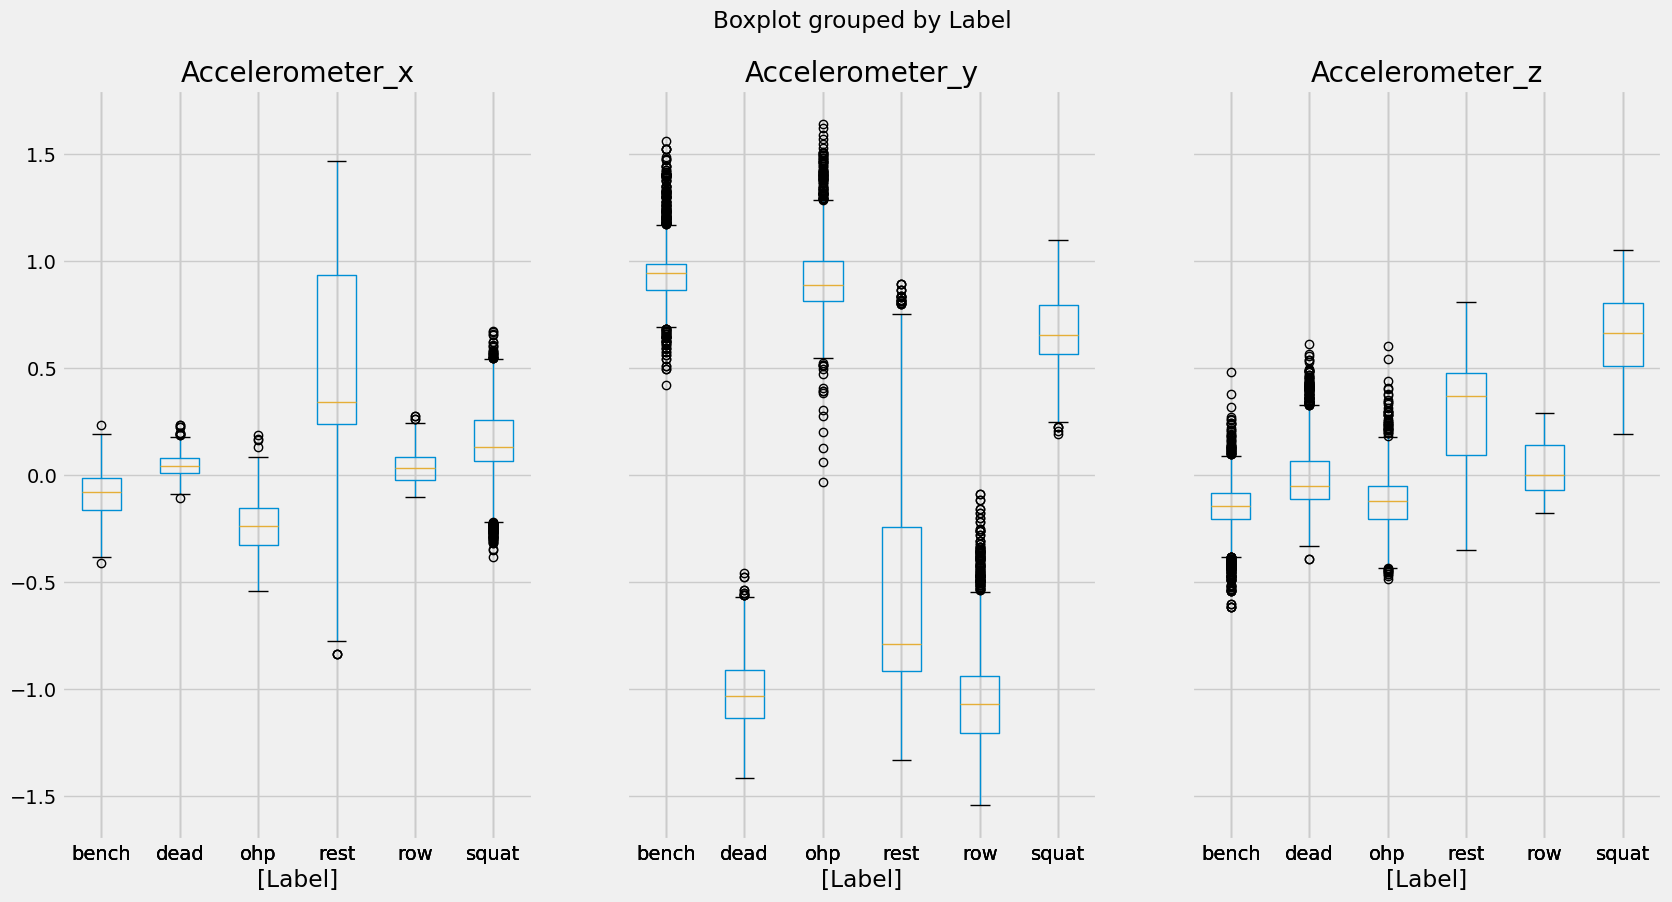

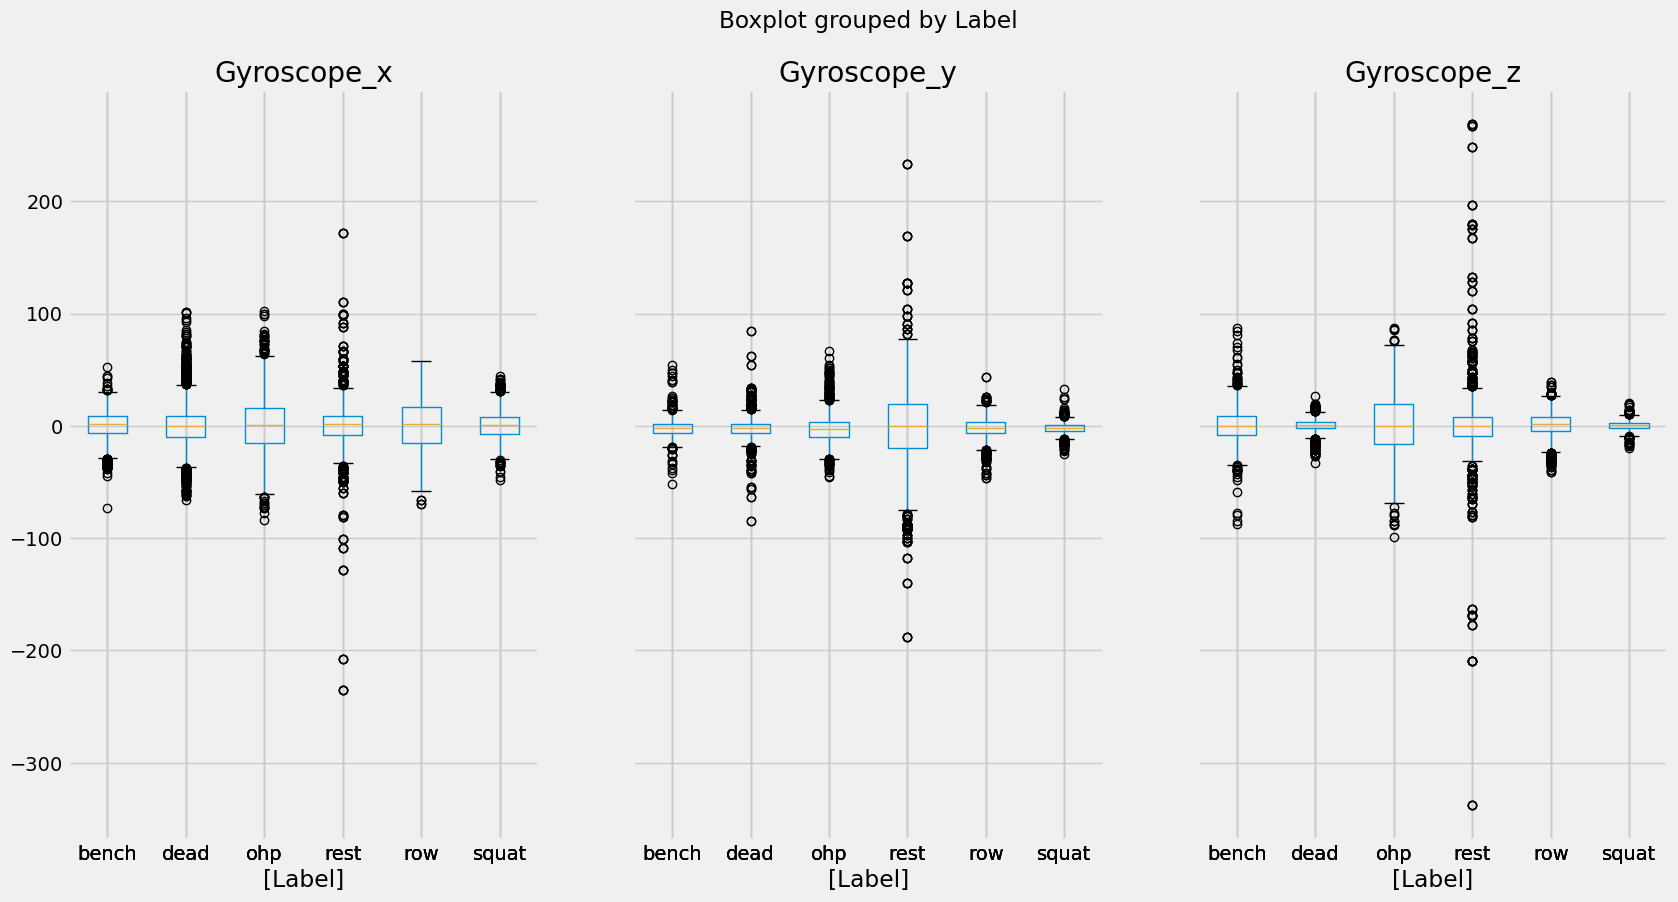

In [3]:
outlier_col=list(df.columns[:6])
df[outlier_col[:3]+["Label"]].boxplot(by="Label",figsize=(20,10),layout=(1,3))
df[outlier_col[3:6]+["Label"]].boxplot(by="Label",figsize=(20,10),layout=(1,3))

In [4]:


def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()


def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset


def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset


def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

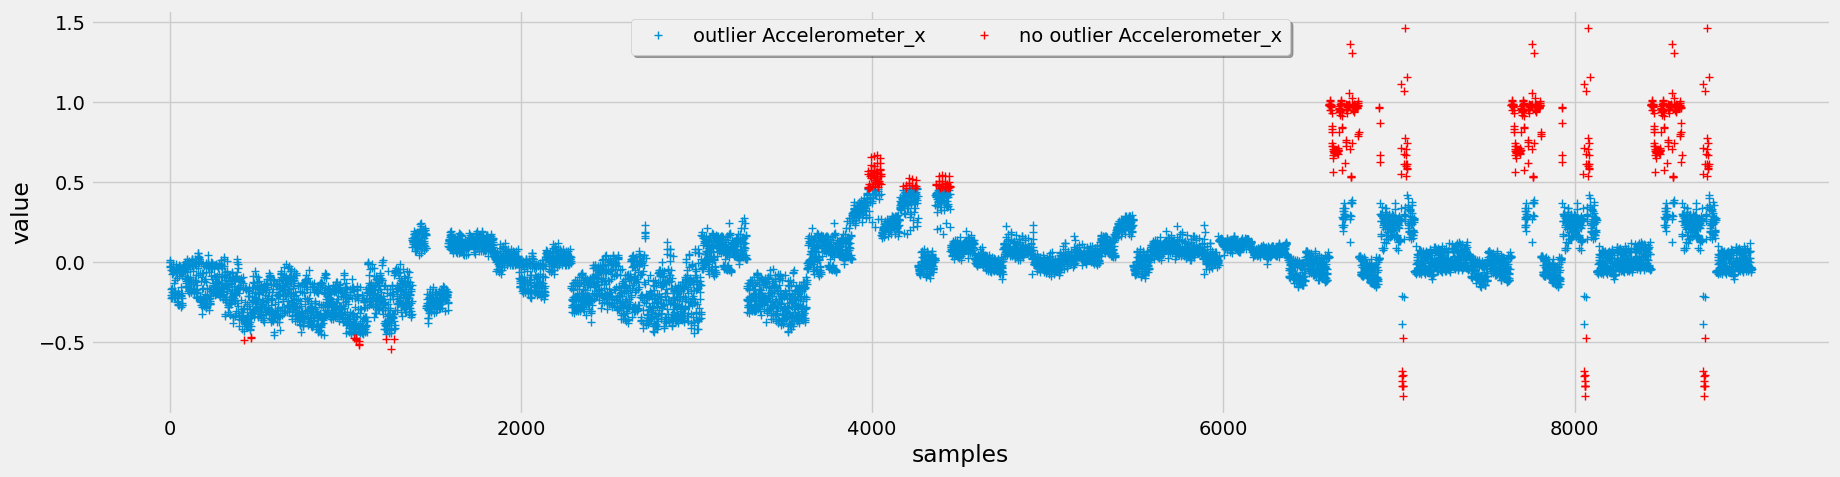

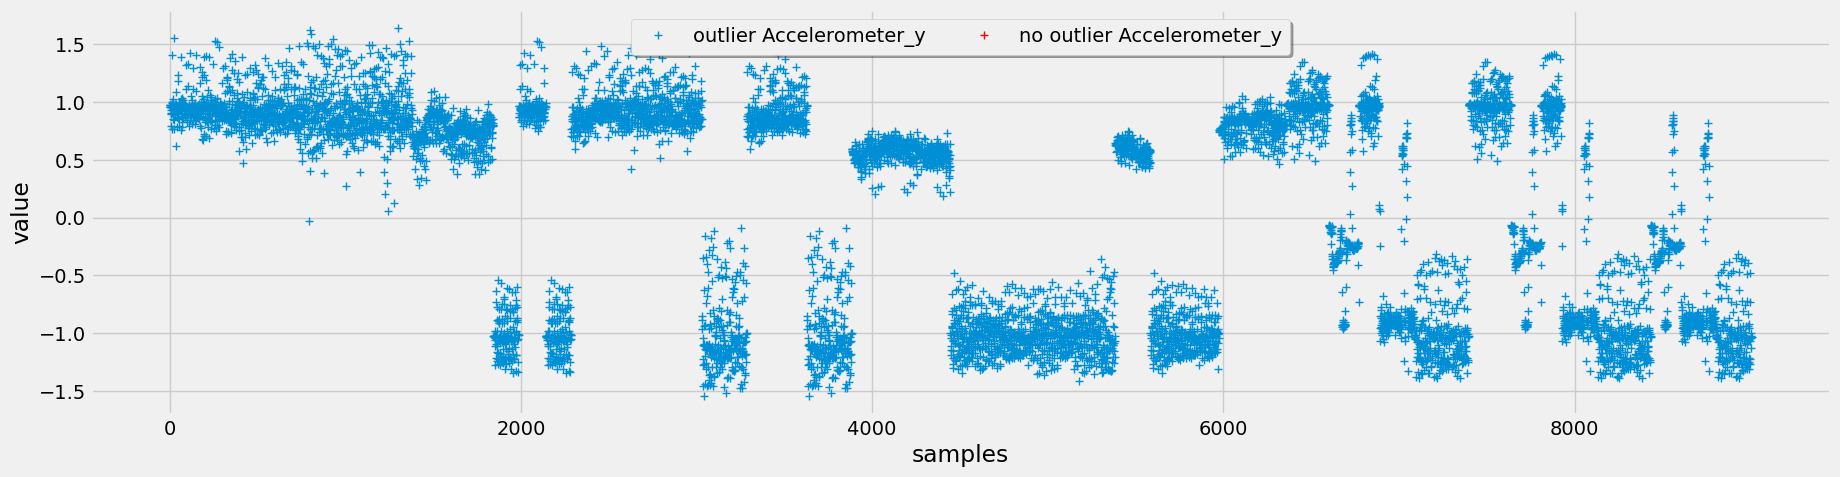

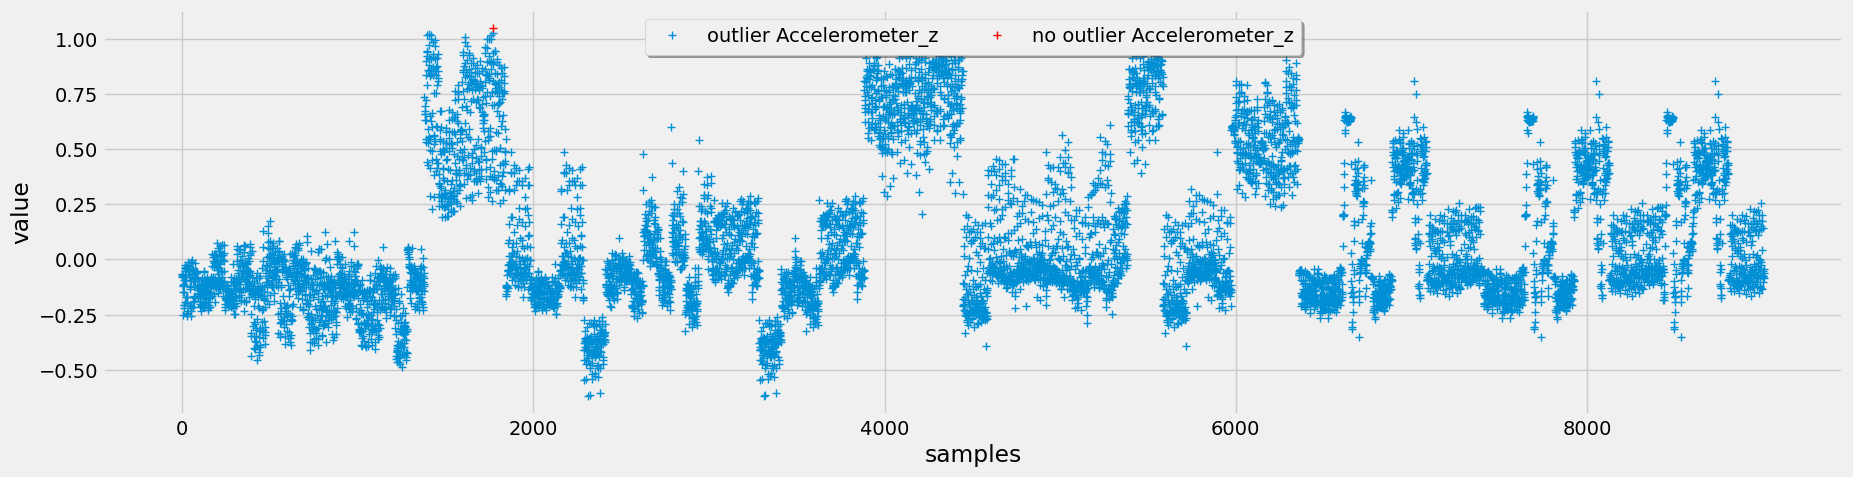

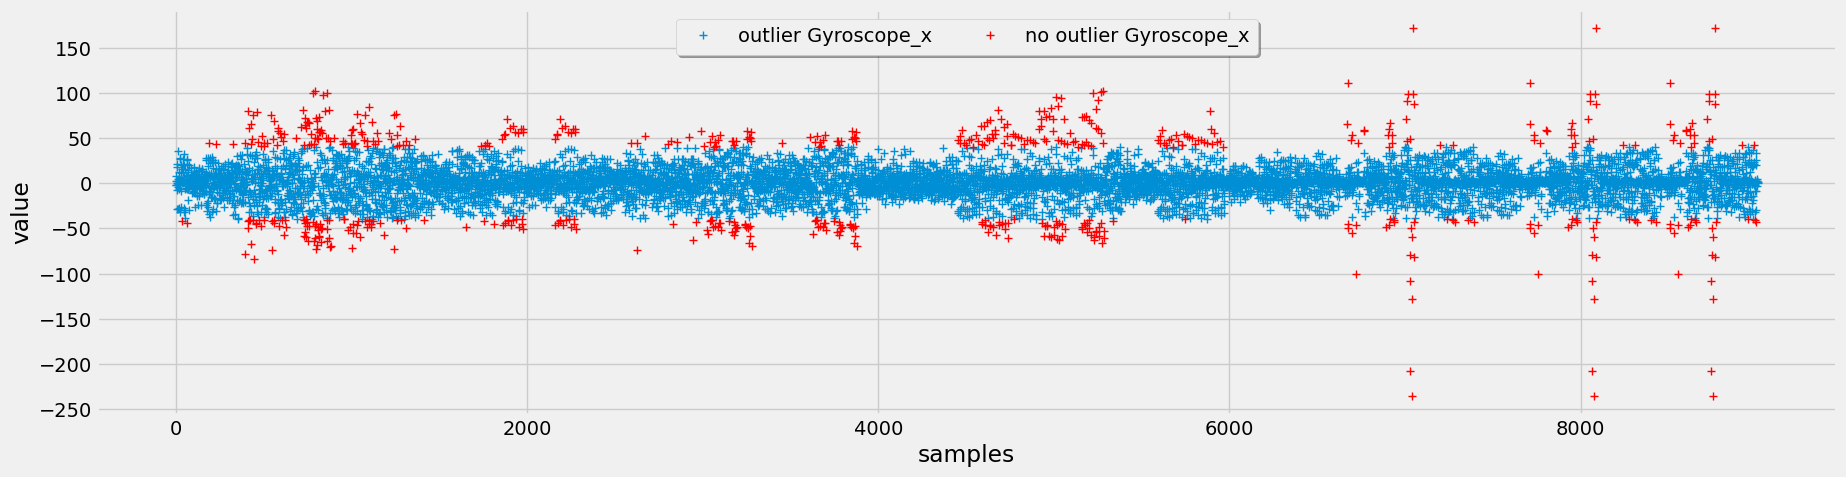

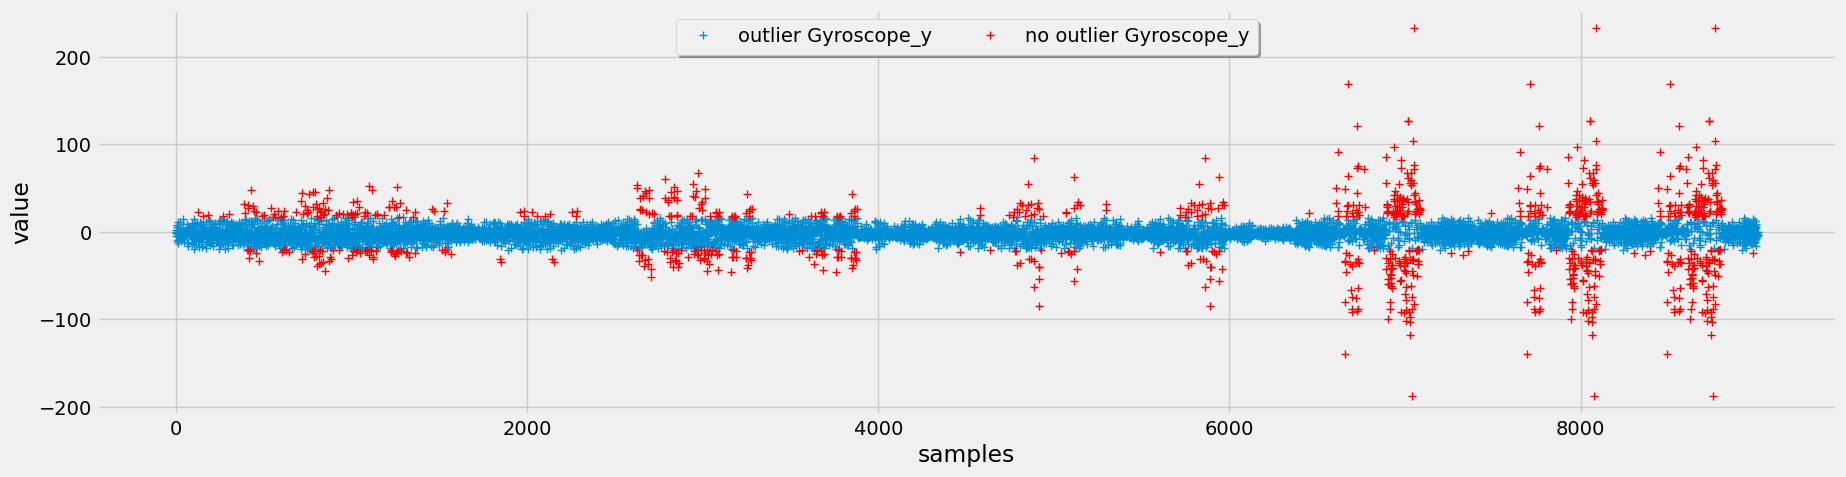

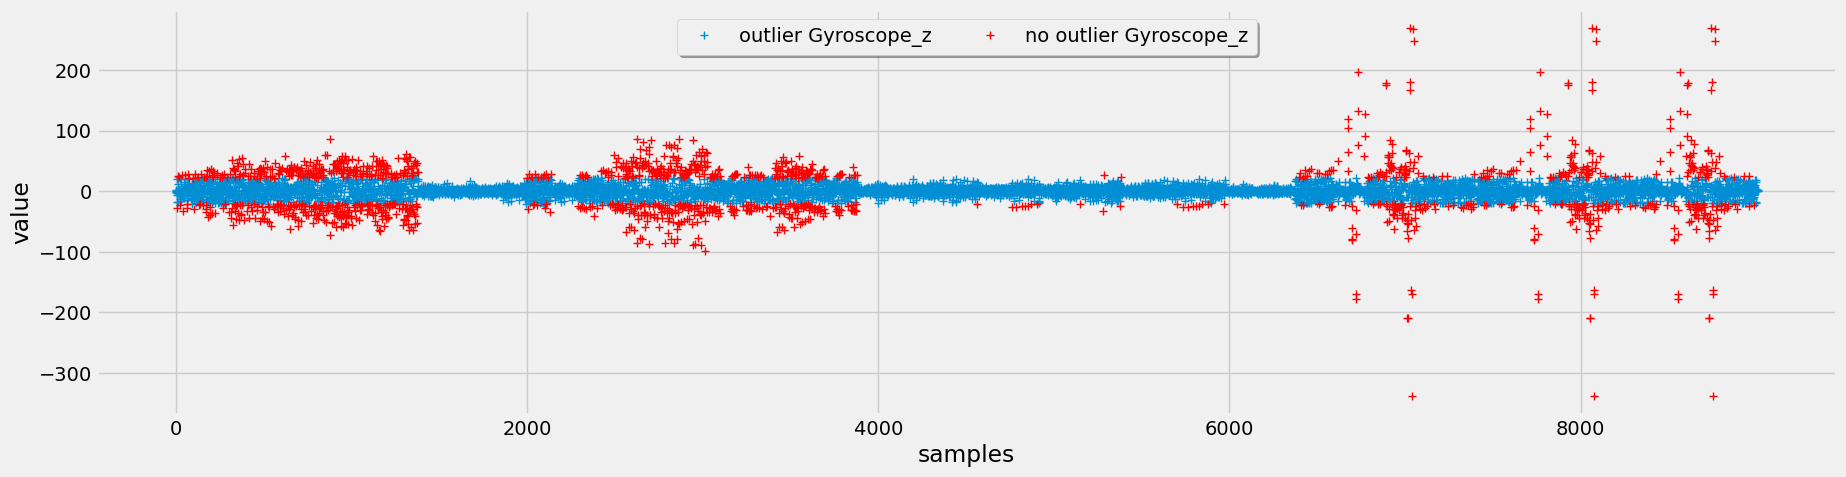

In [5]:
for col in outlier_col:
    dataset=mark_outliers_iqr(df,col)
    plot_binary_outliers(dataset,col,col+"_outlier",True)

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

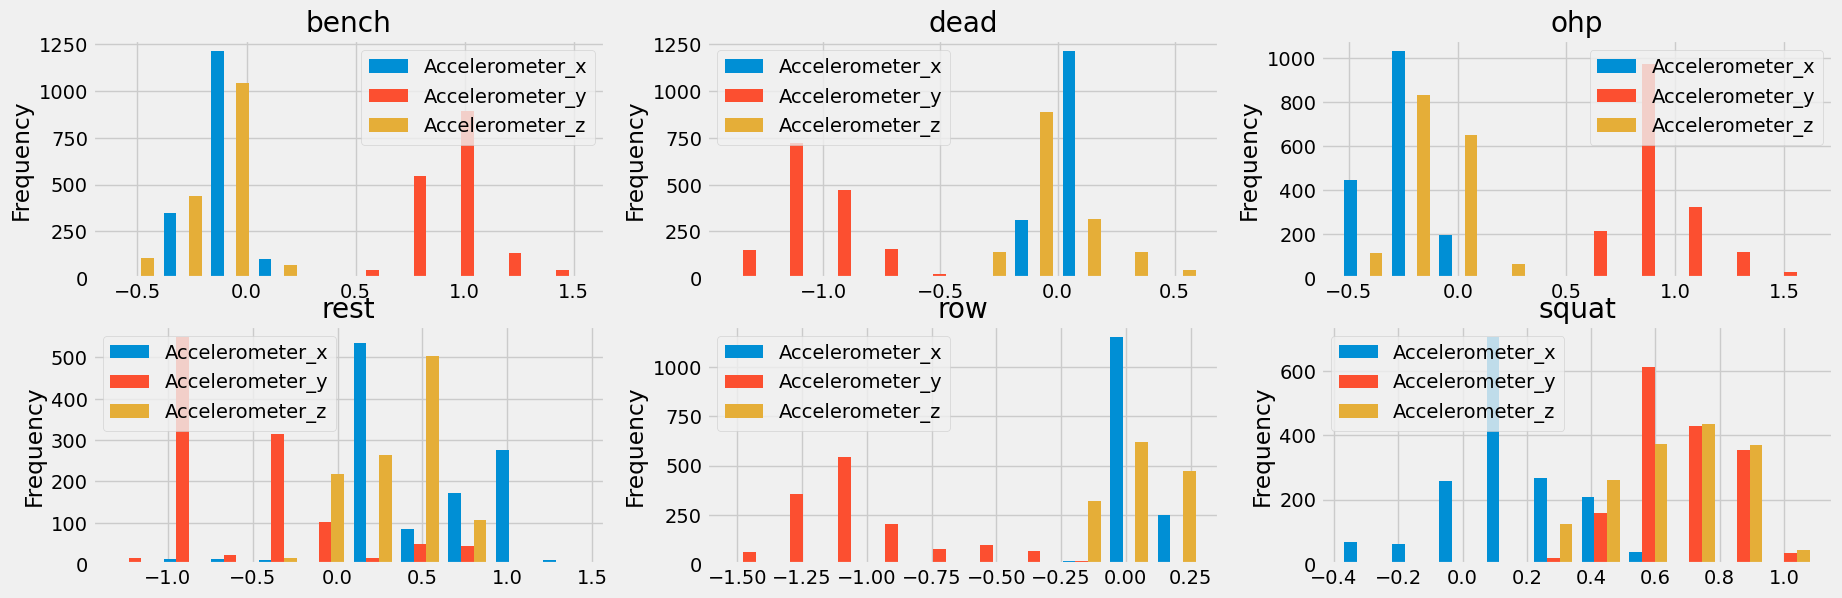

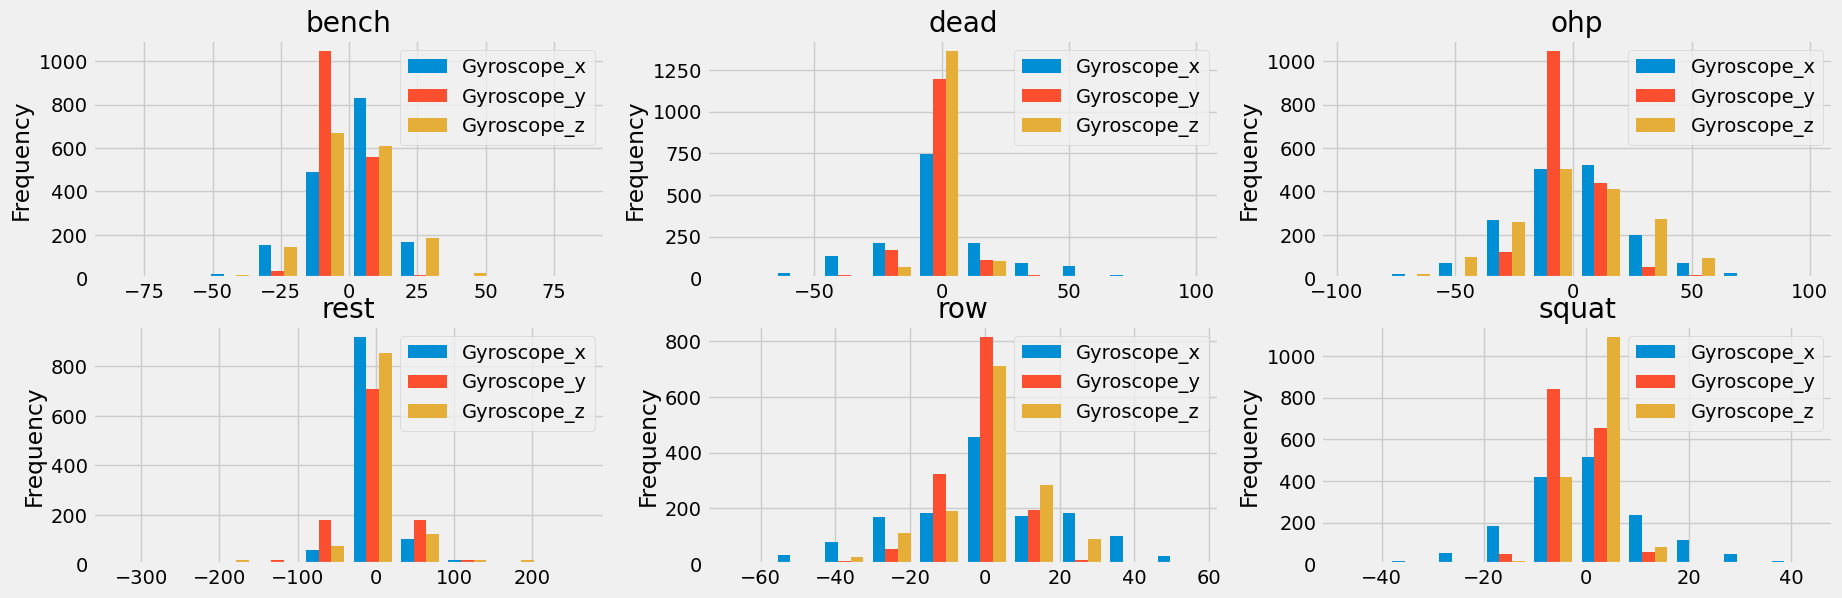

In [6]:
df[outlier_col[:3]+["Label"]].plot.hist(by="Label",figsize=(20,10),layout=(3,3))
df[outlier_col[3:6]+["Label"]].plot.hist(by="Label",figsize=(20,10),layout=(3,3))

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


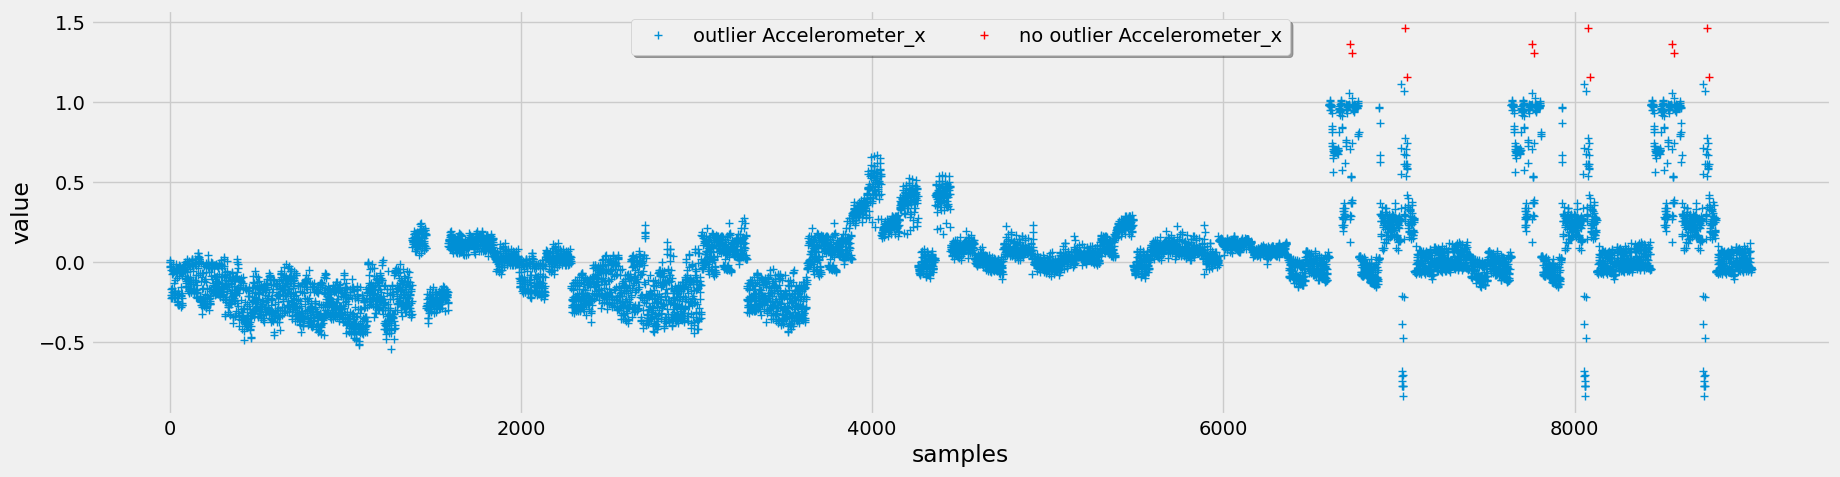

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


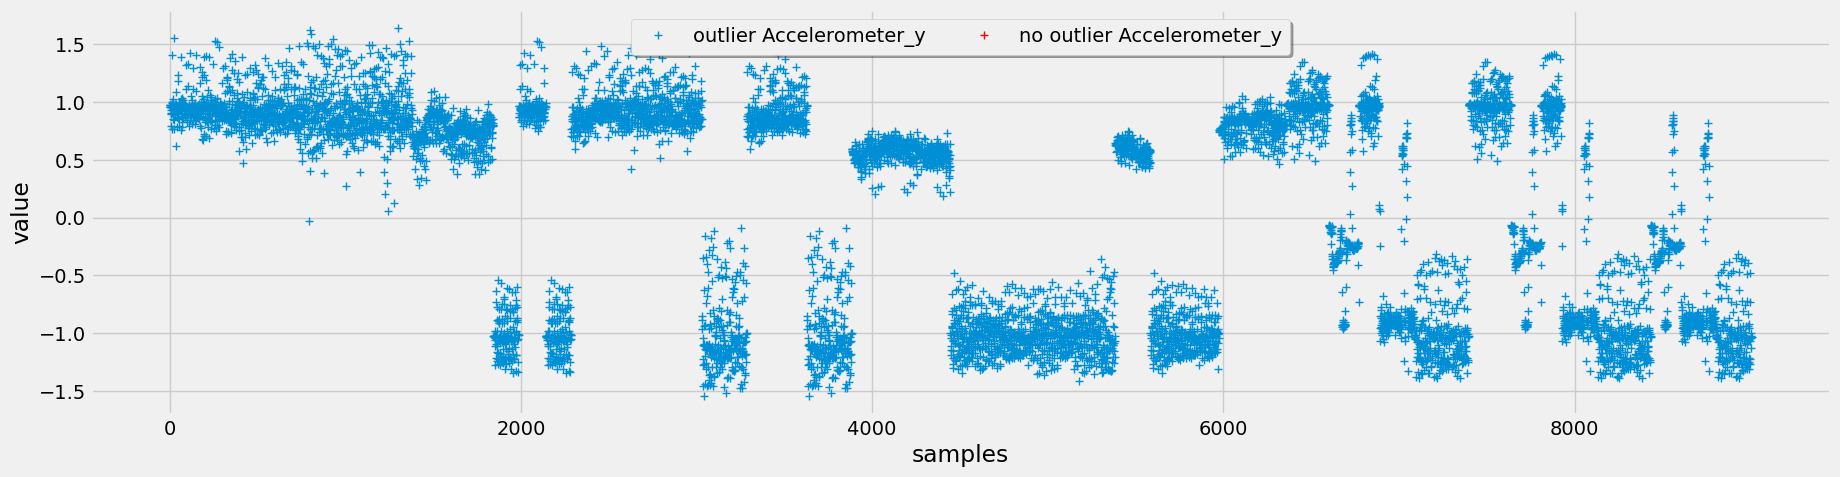

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


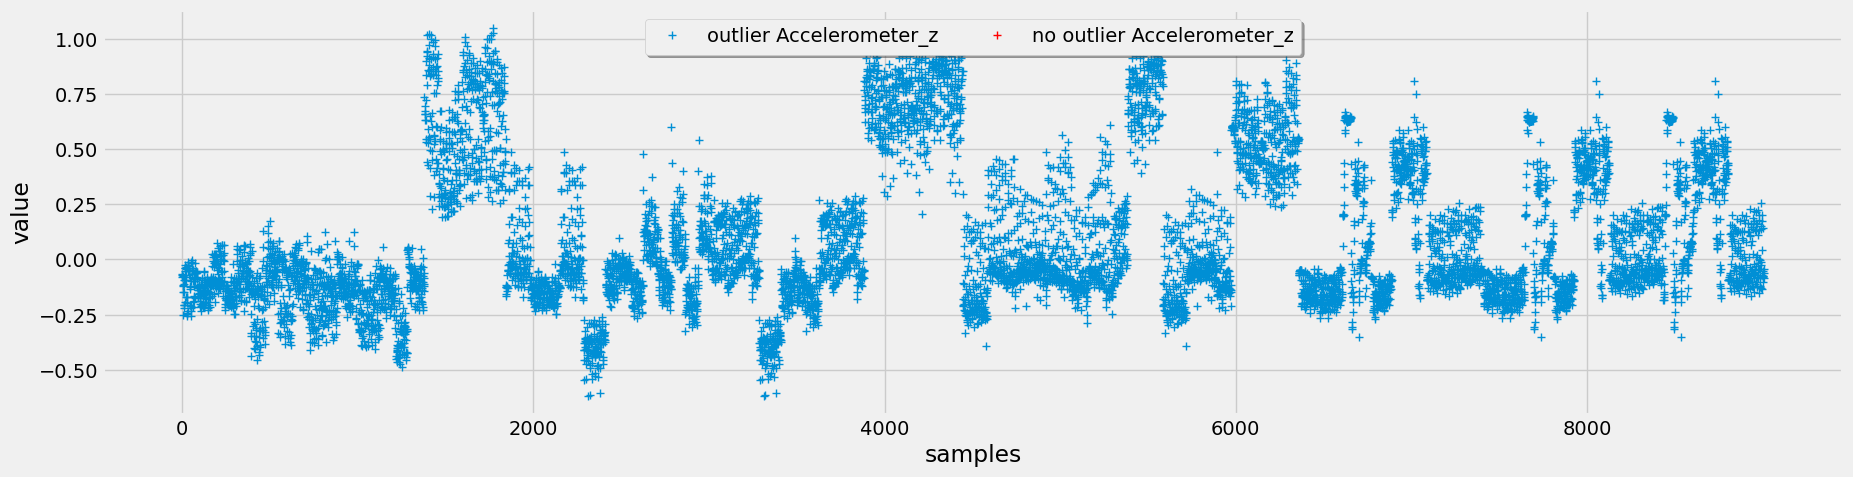

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


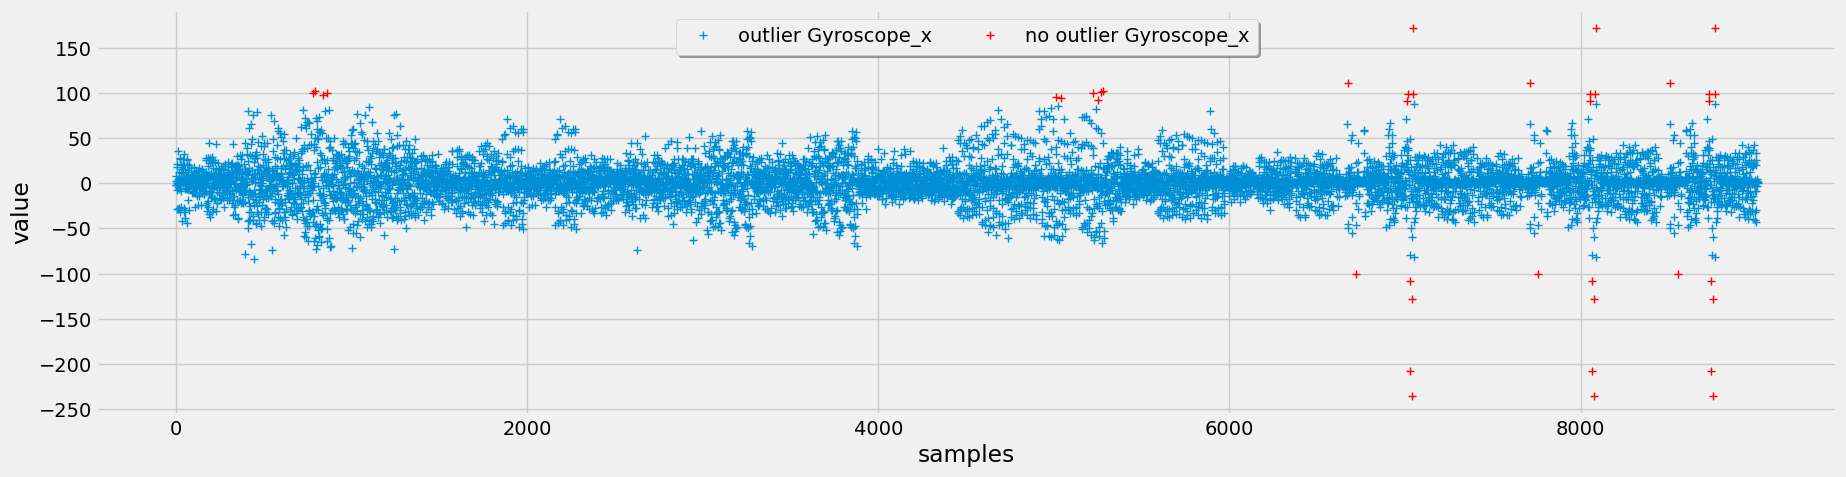

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


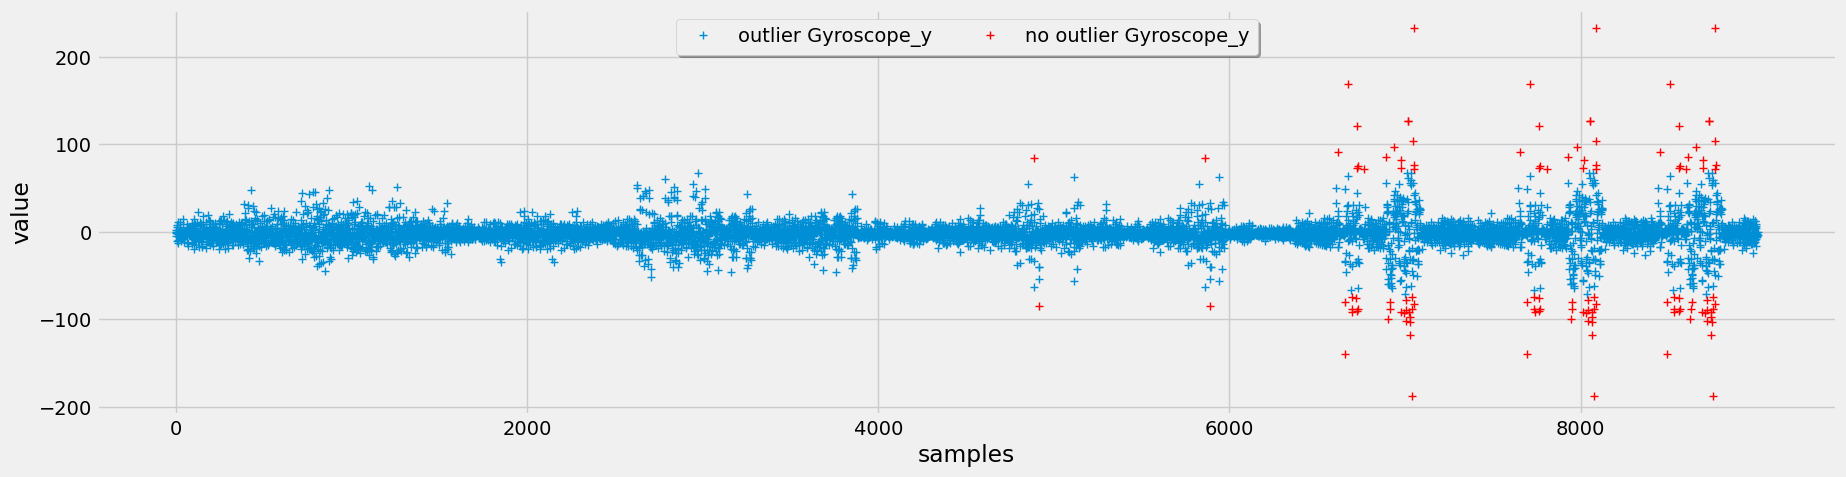

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


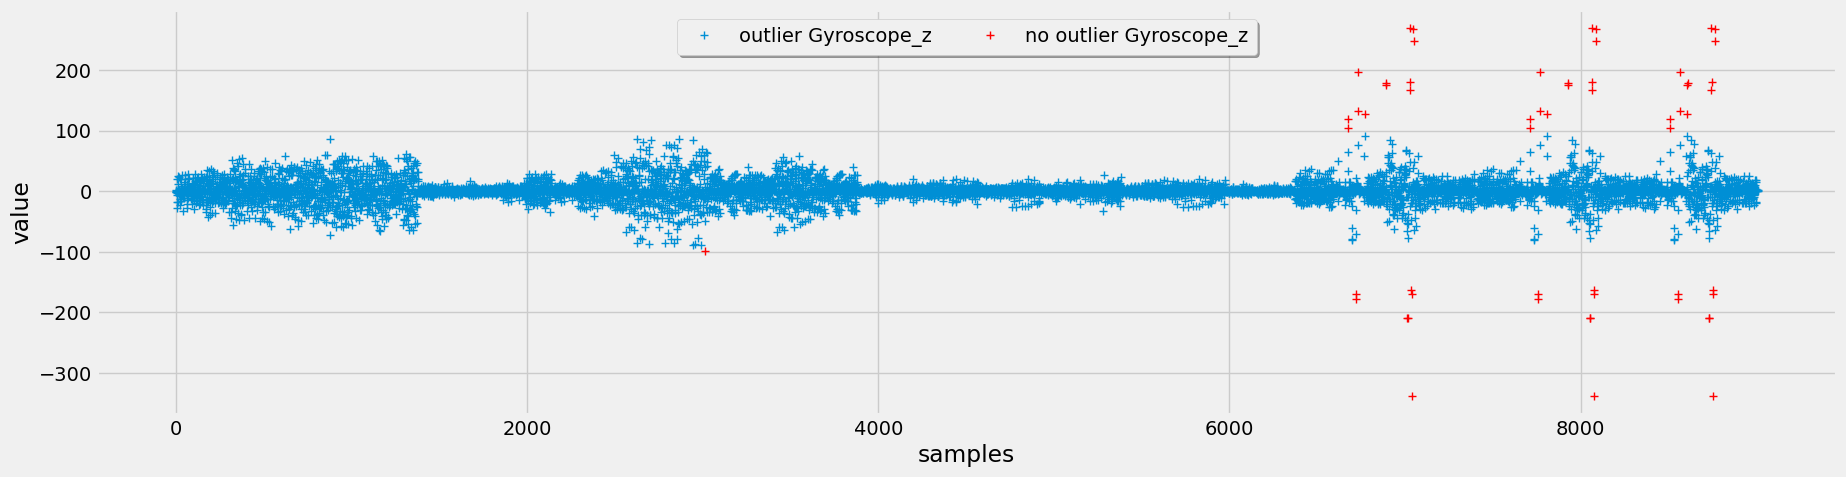

In [7]:
for col in outlier_col:
    dataset=mark_outliers_chauvenet(df,col)
    plot_binary_outliers(dataset,col,col+"_outlier",True)

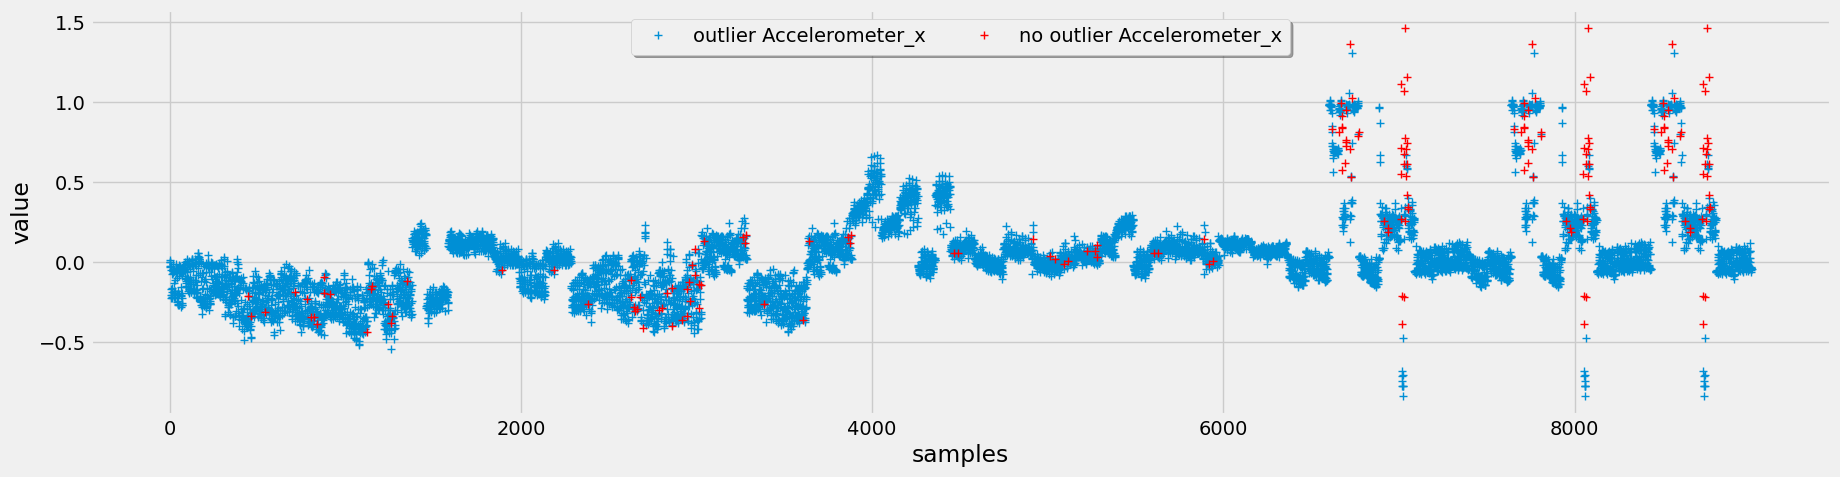

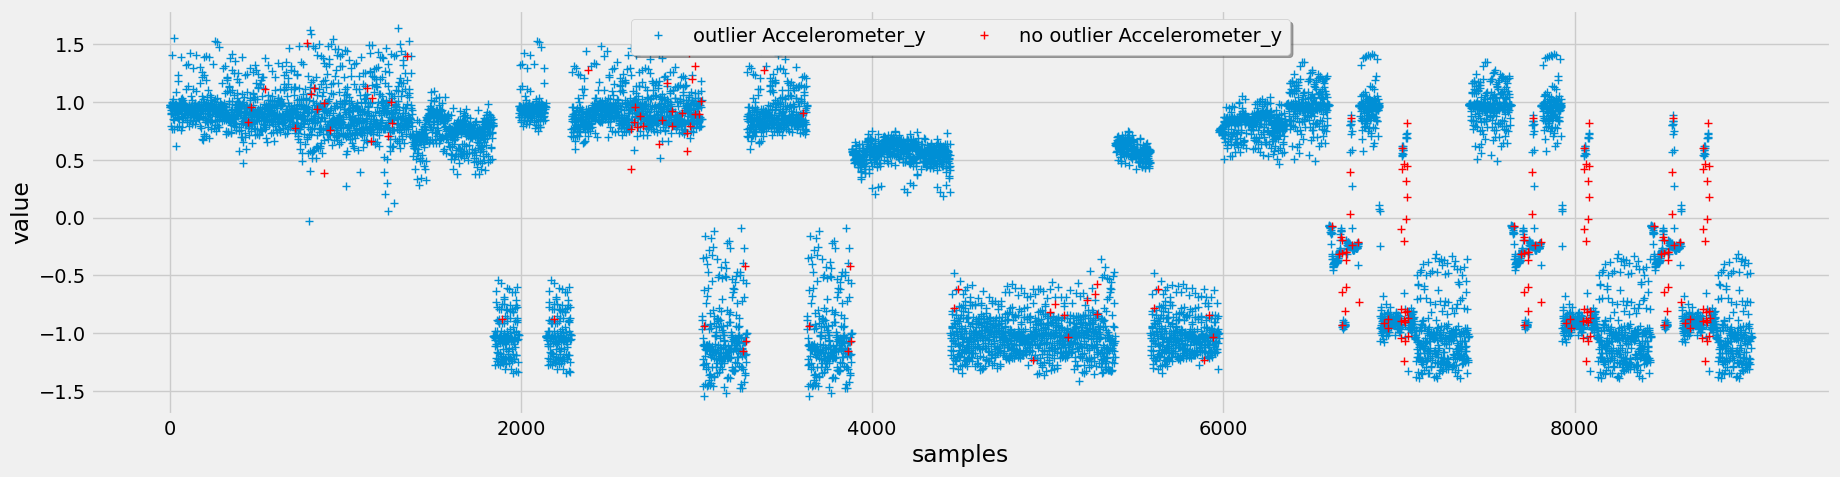

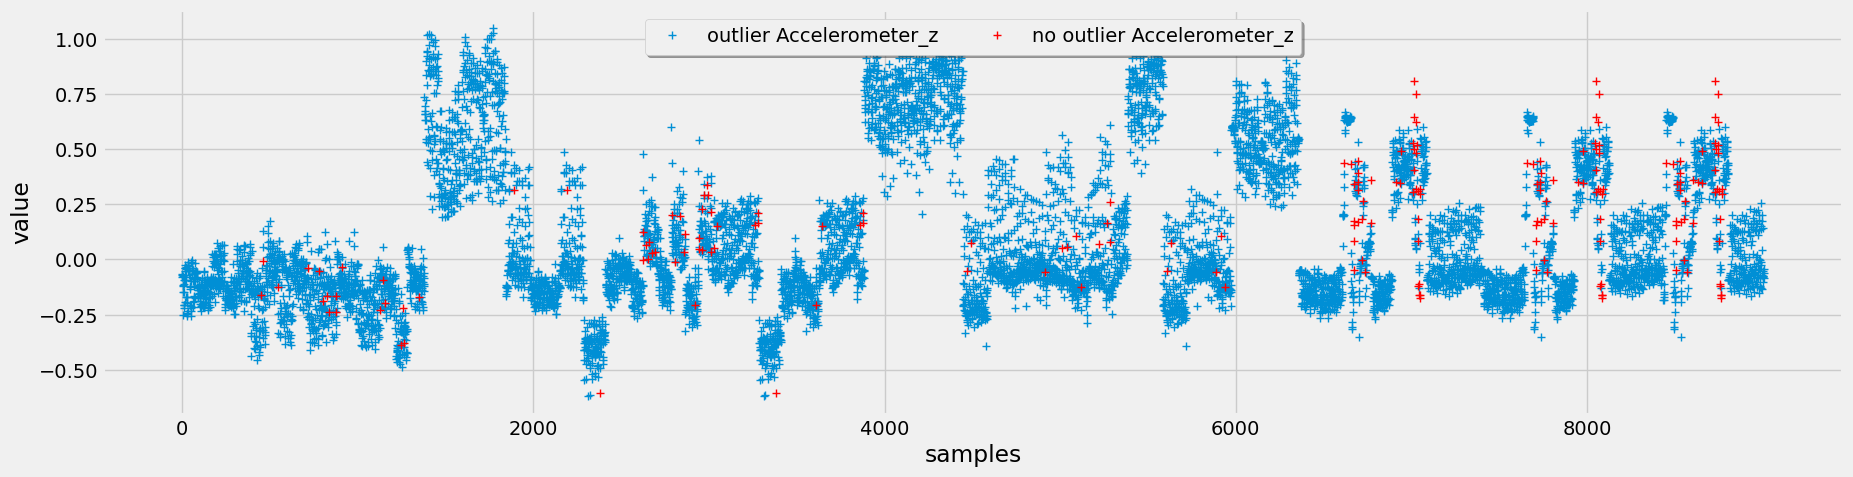

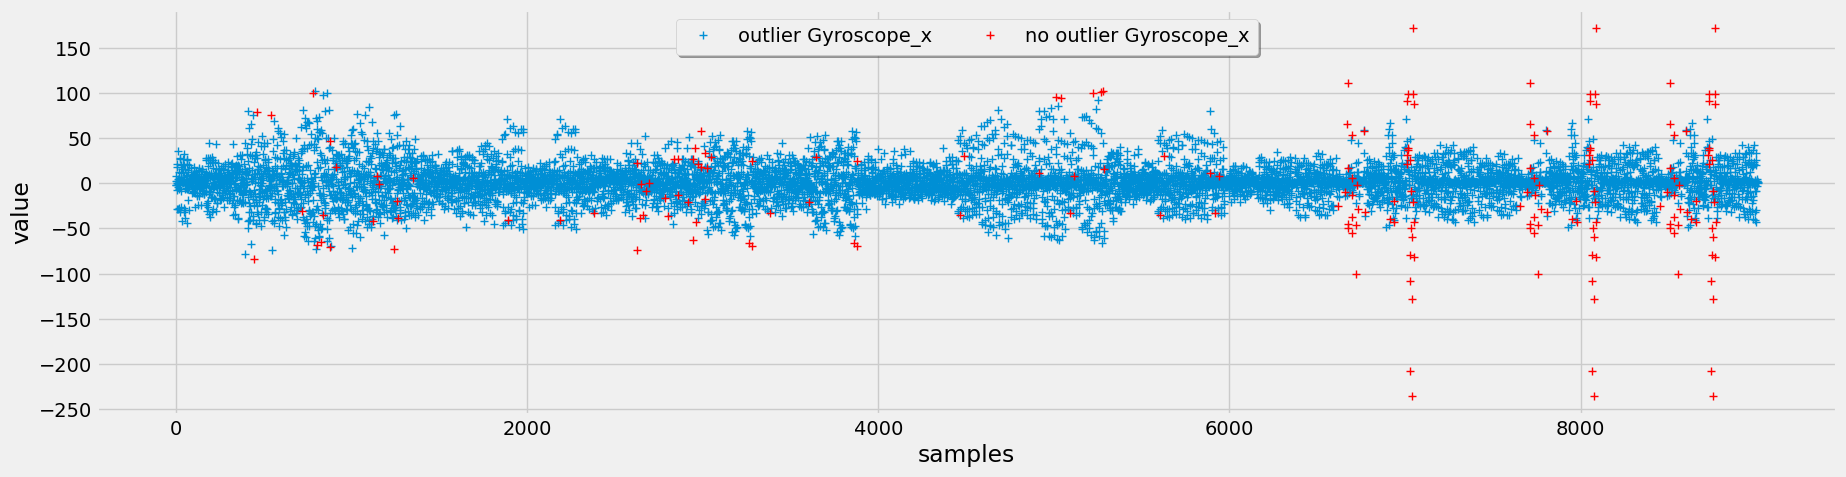

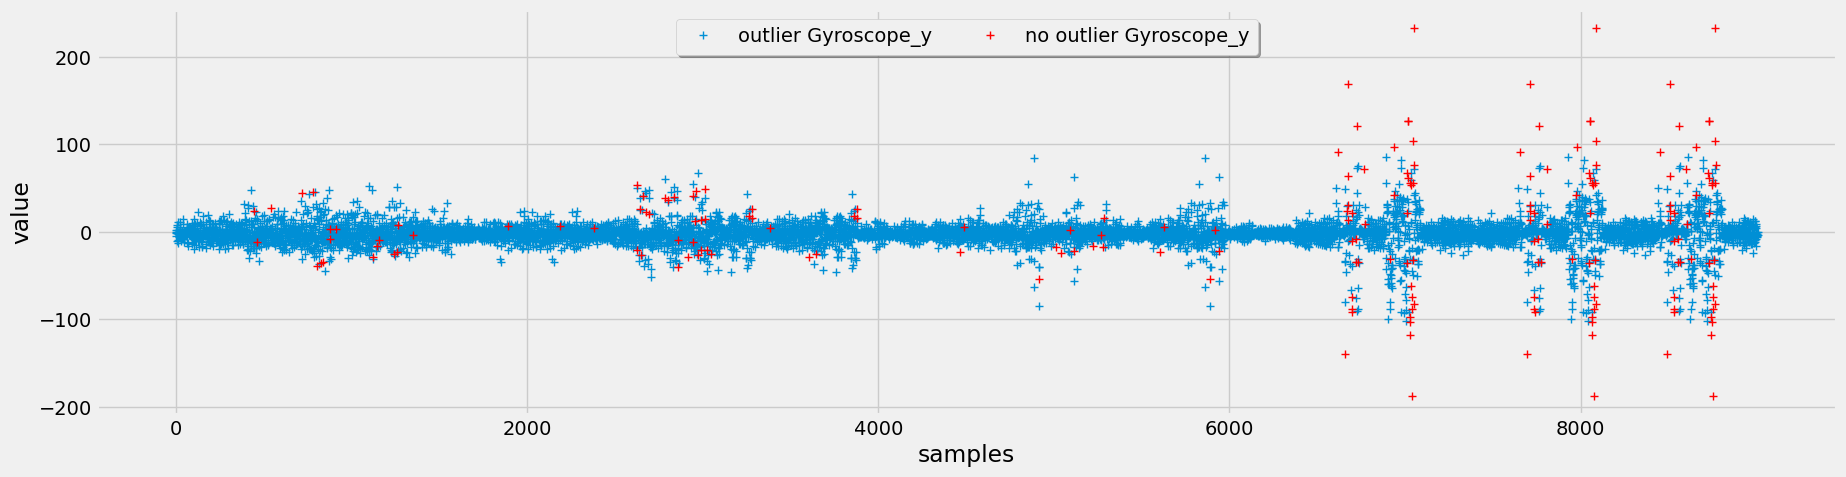

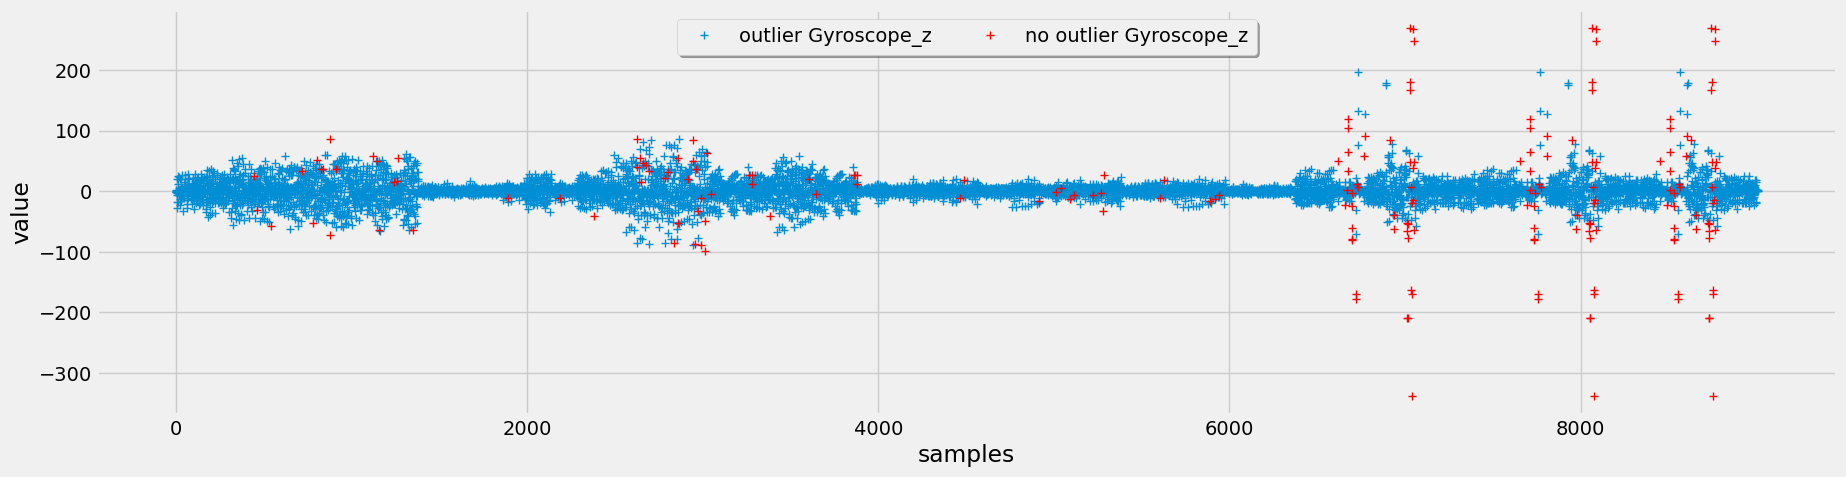

In [8]:
dataset,out,x=mark_outliers_lof(df,outlier_col)

for col in outlier_col:
    plot_binary_outliers(dataset,col,"outlier_lof",True)

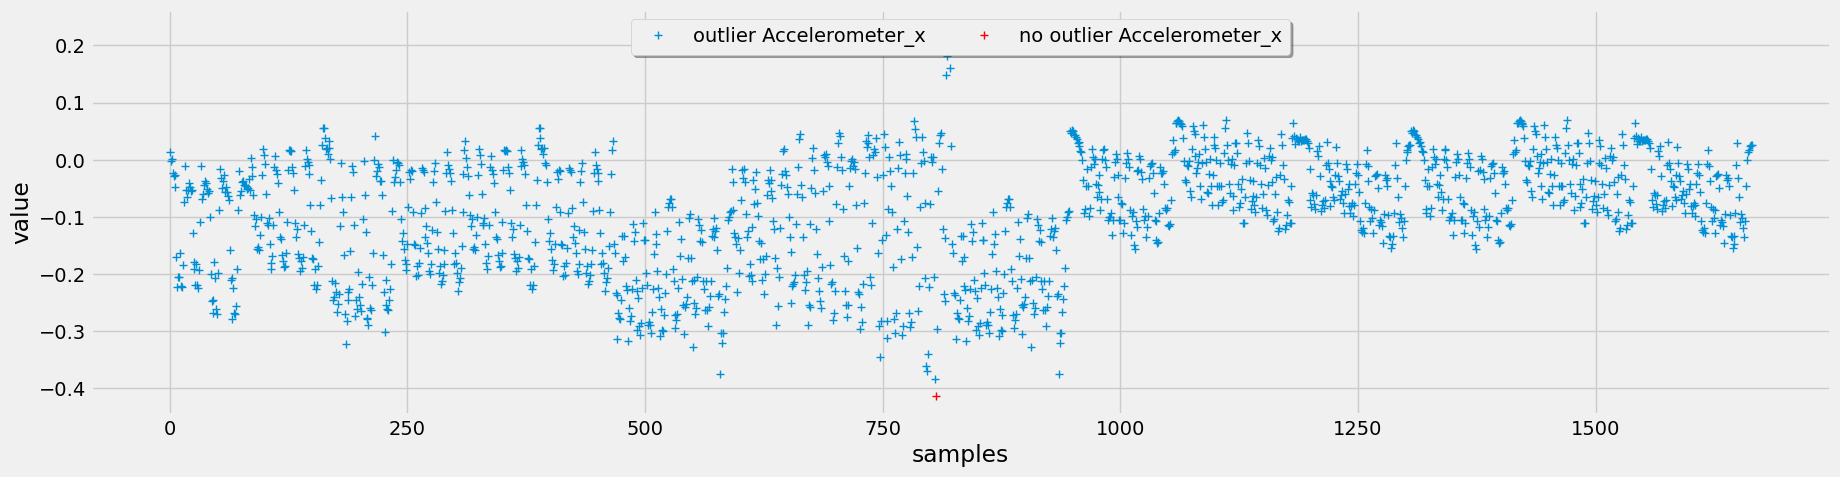

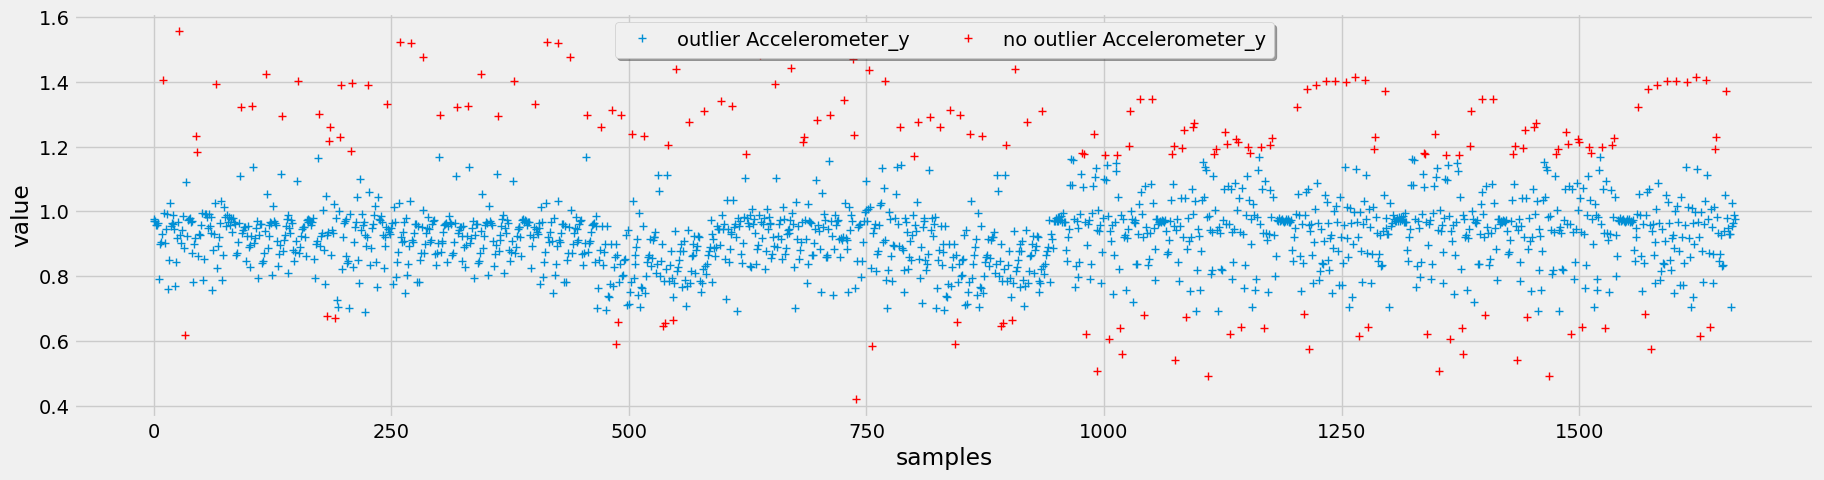

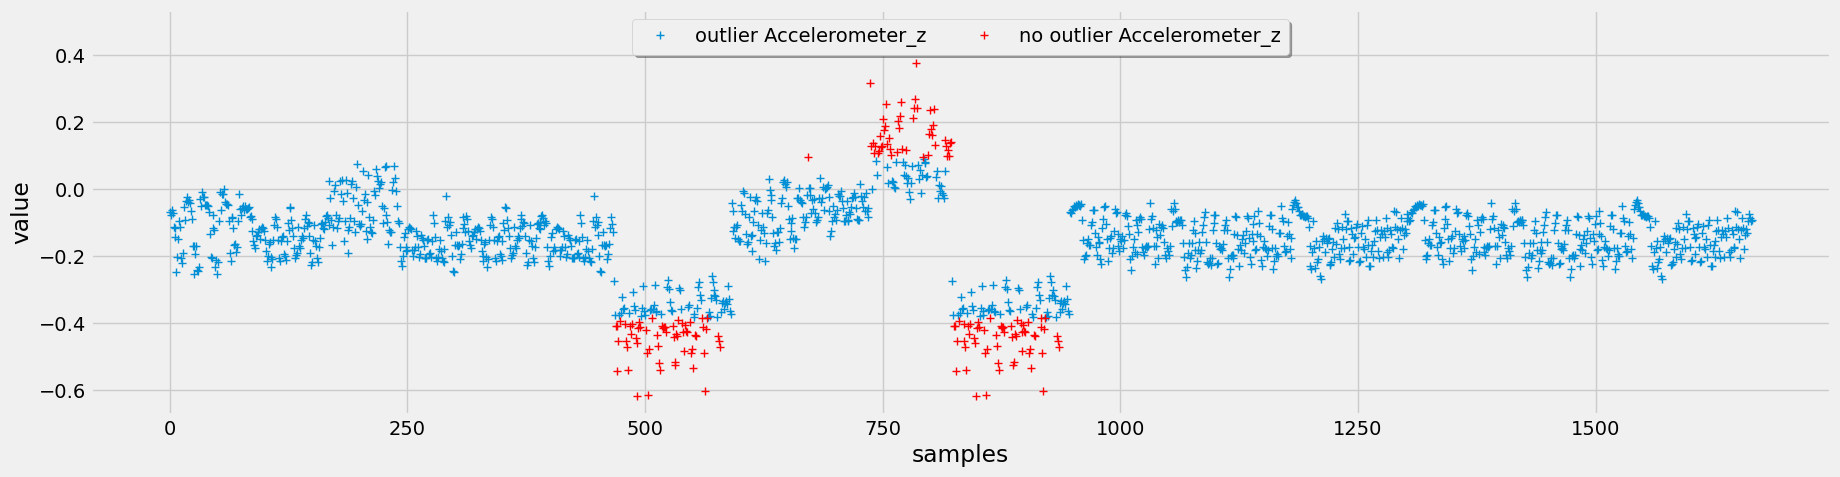

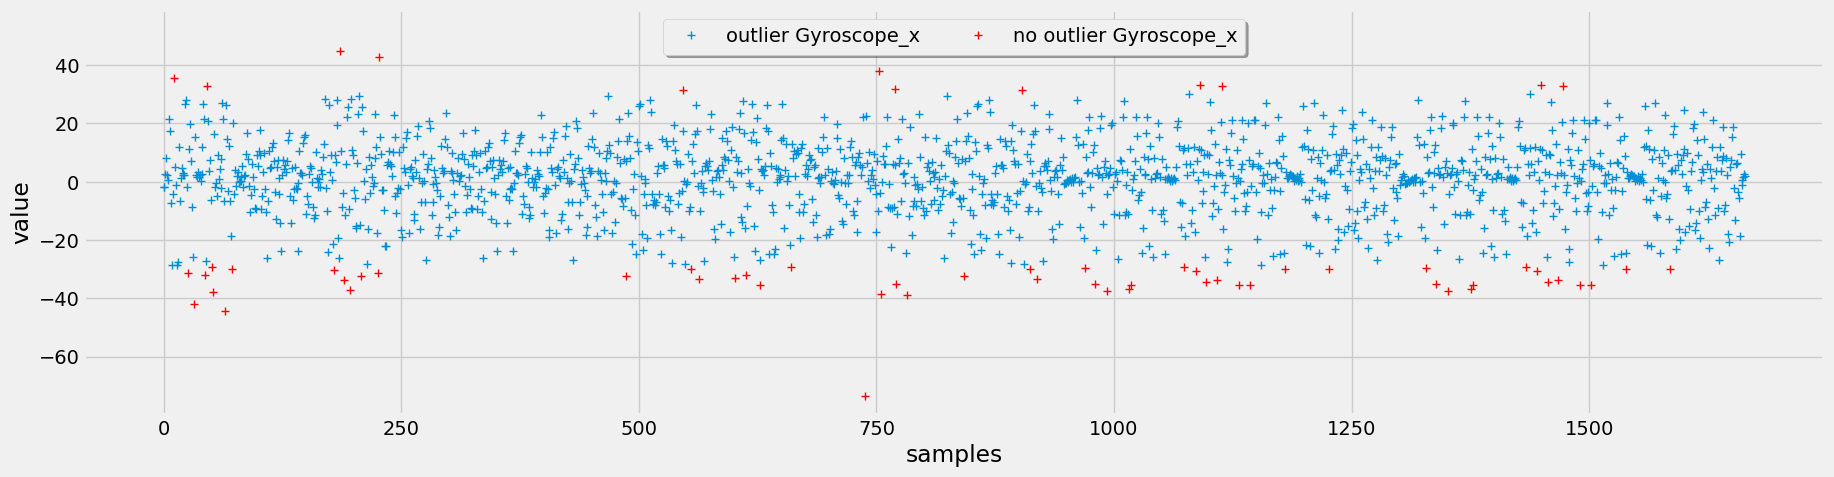

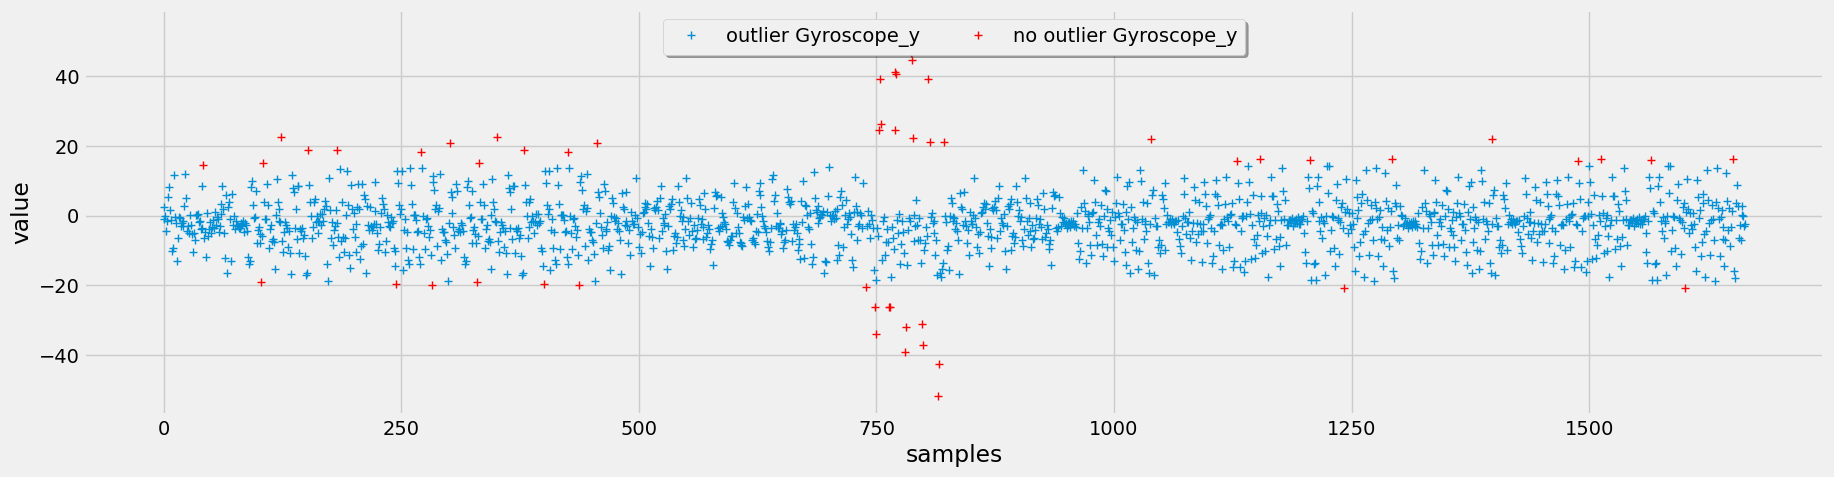

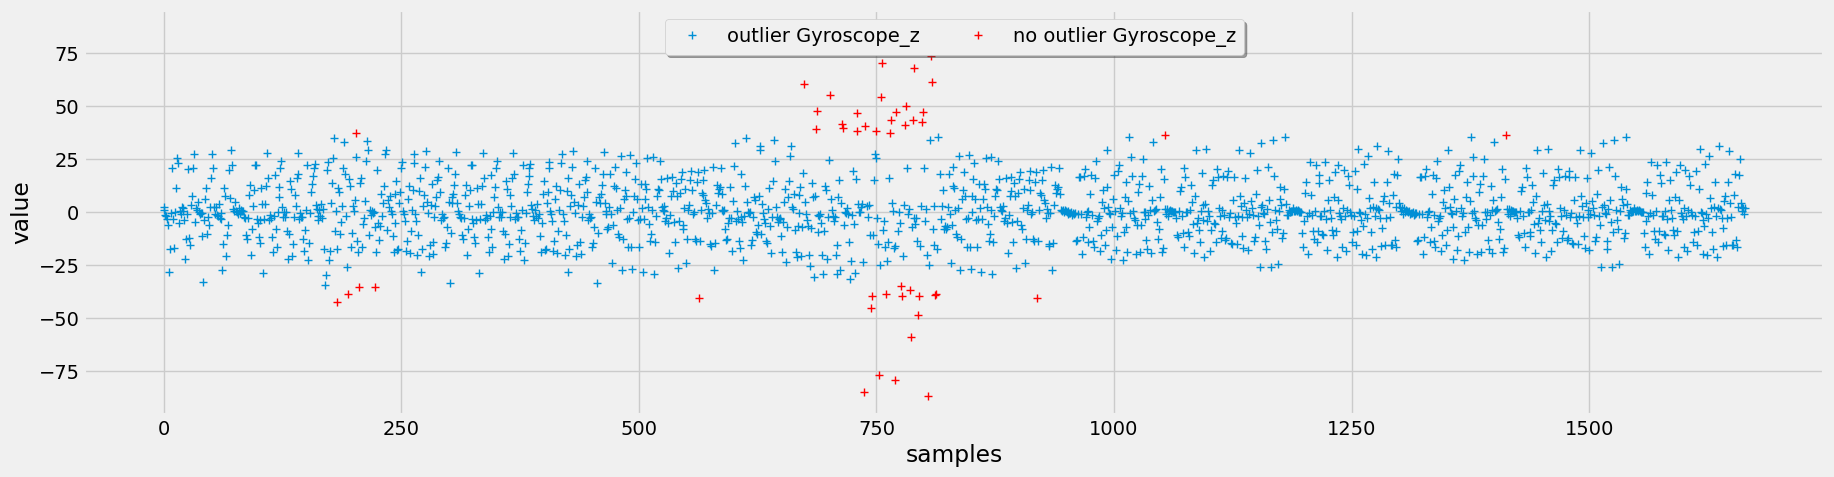

In [9]:
label="bench"
for col in outlier_col:
    dataset=mark_outliers_iqr(df[df["Label"]==label],col)
    plot_binary_outliers(dataset,col,col+"_outlier",True)

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


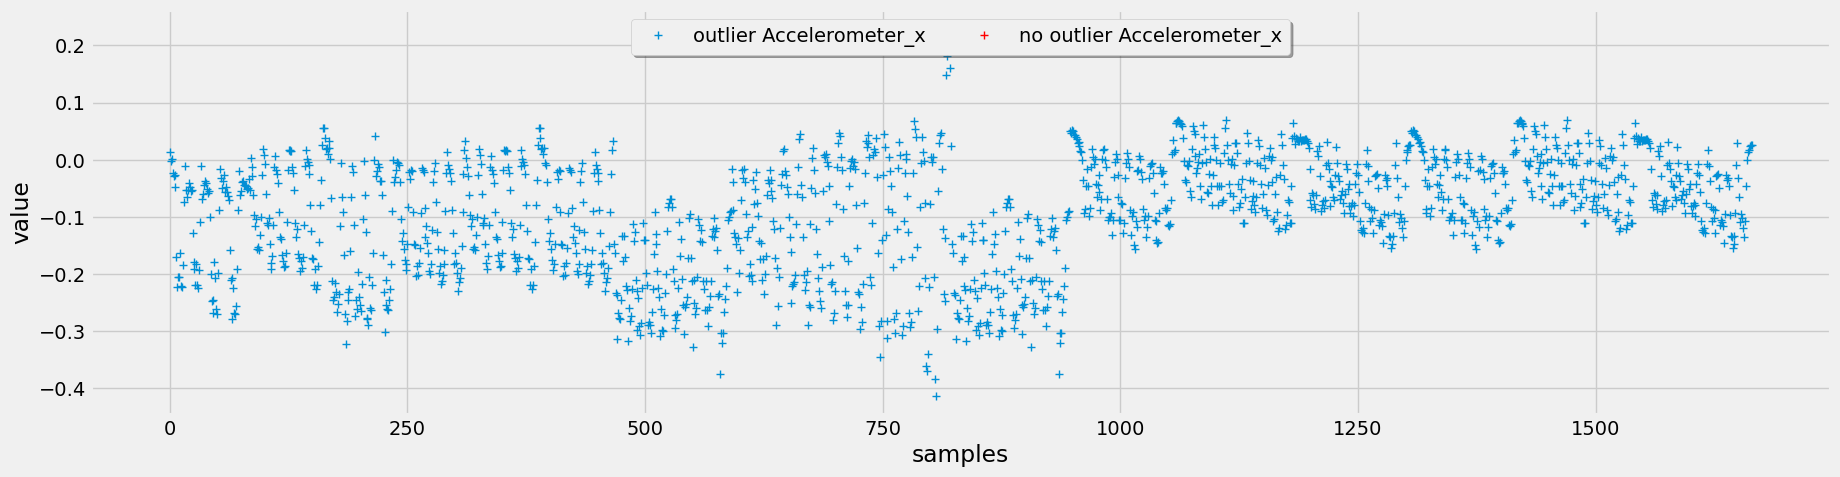

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


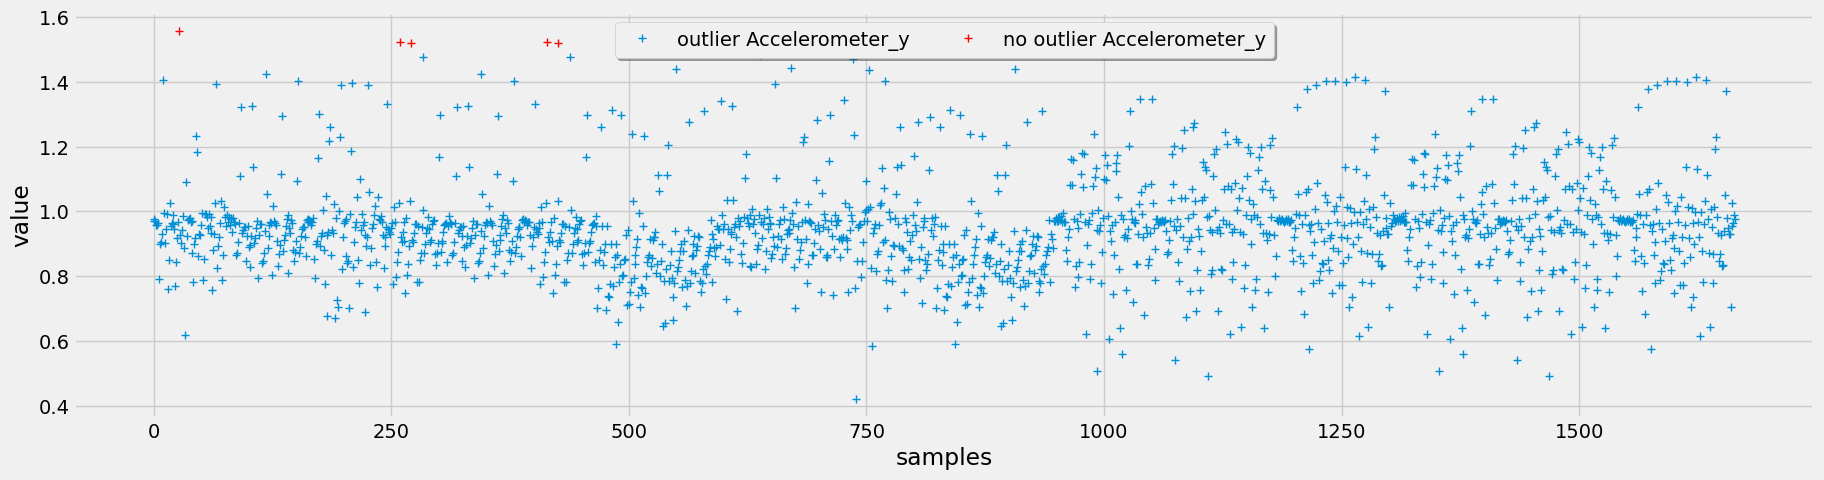

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


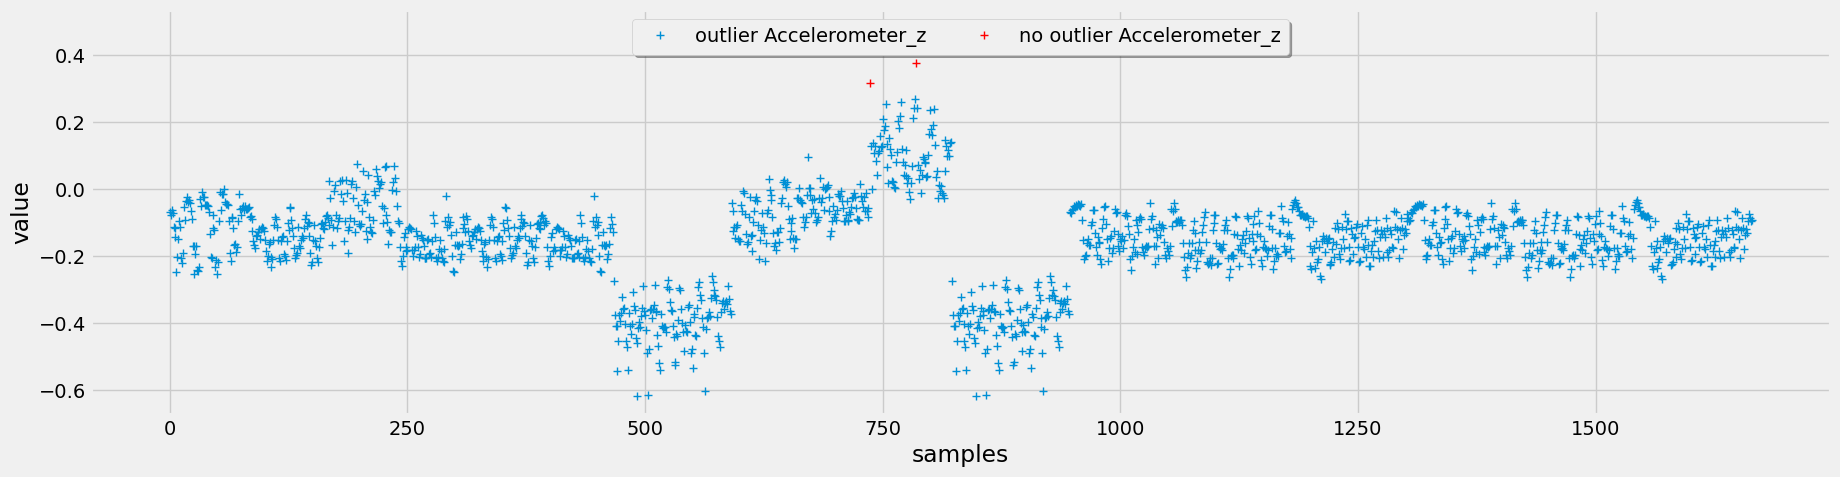

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


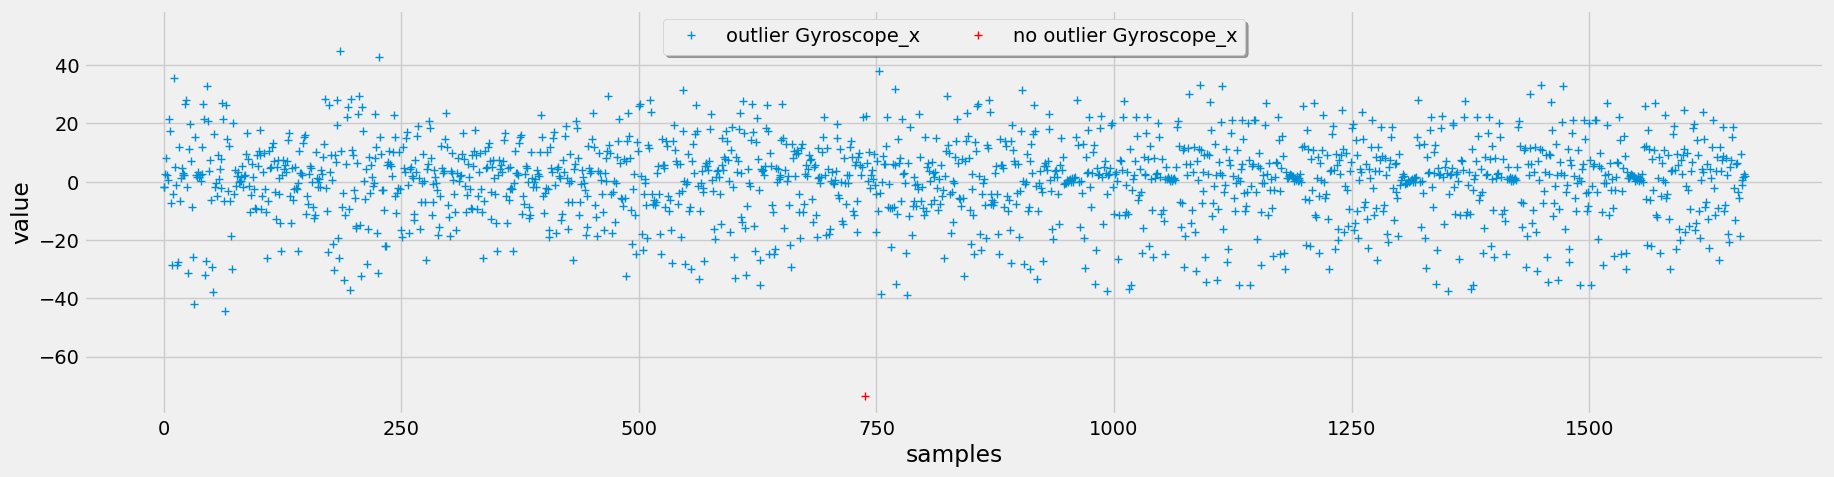

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


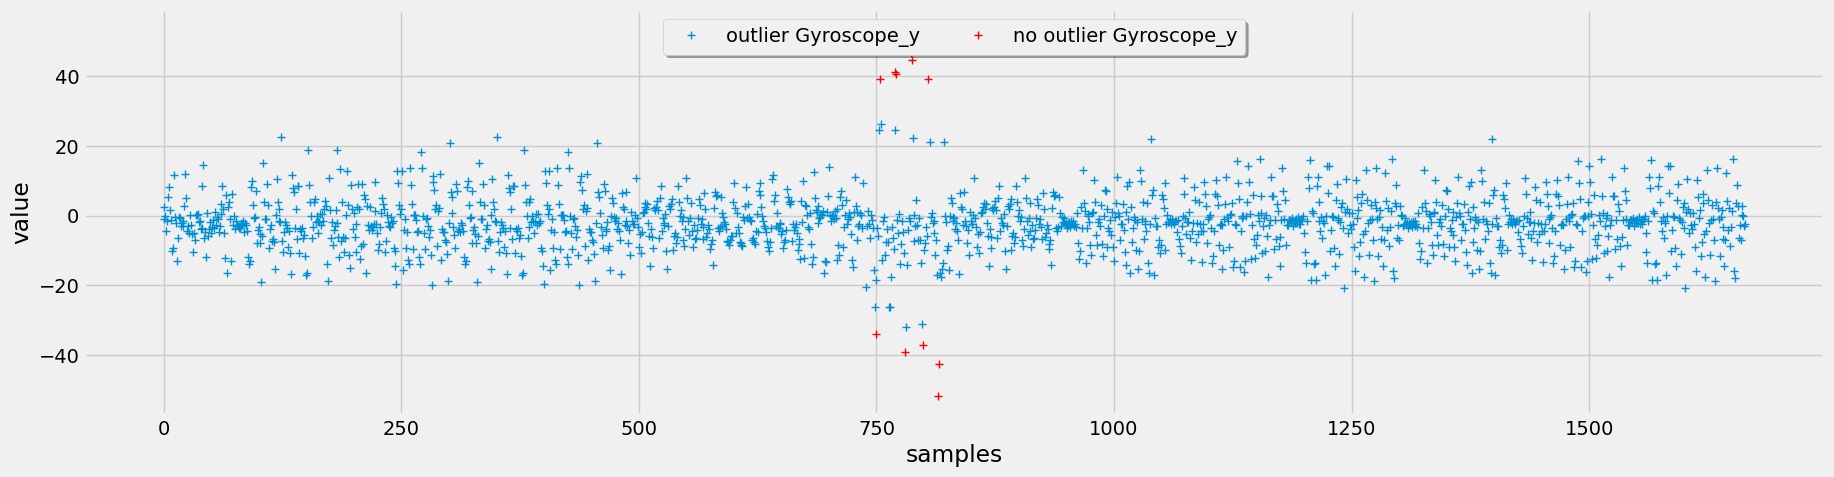

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


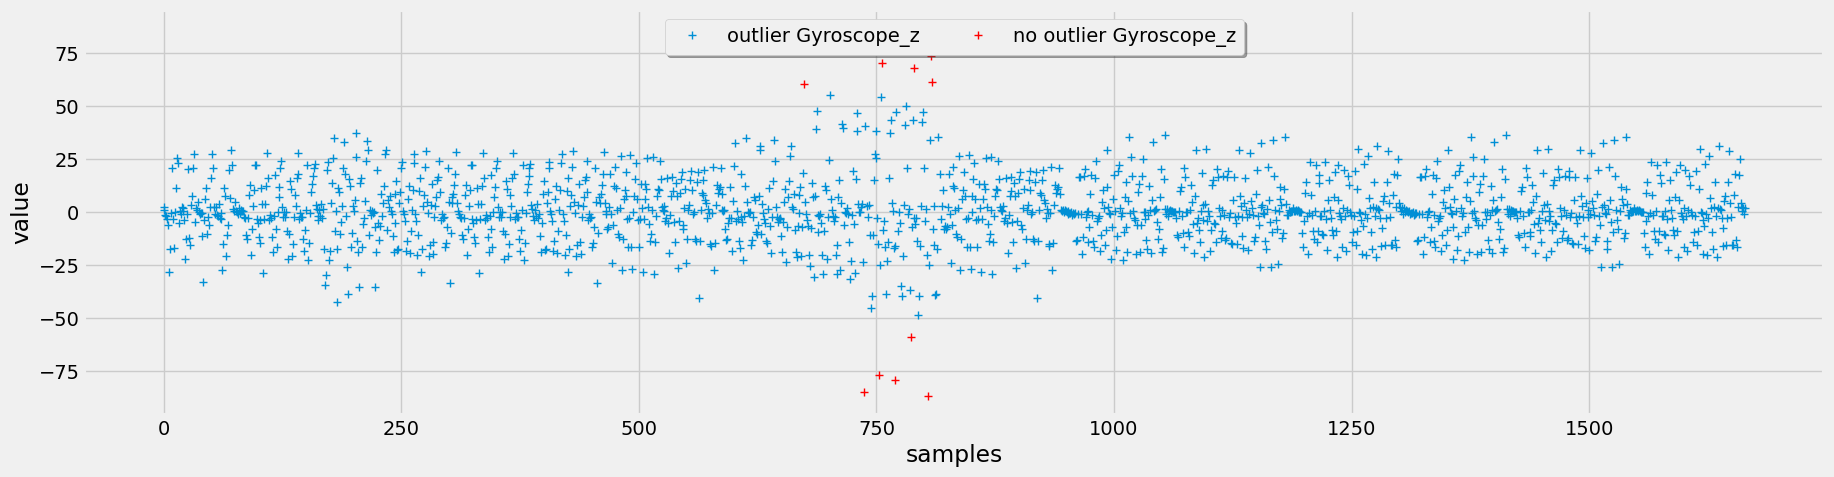

In [10]:
label="bench"
for col in outlier_col:
    dataset=mark_outliers_chauvenet(df[df["Label"]==label],col)
    plot_binary_outliers(dataset,col,col+"_outlier",True)

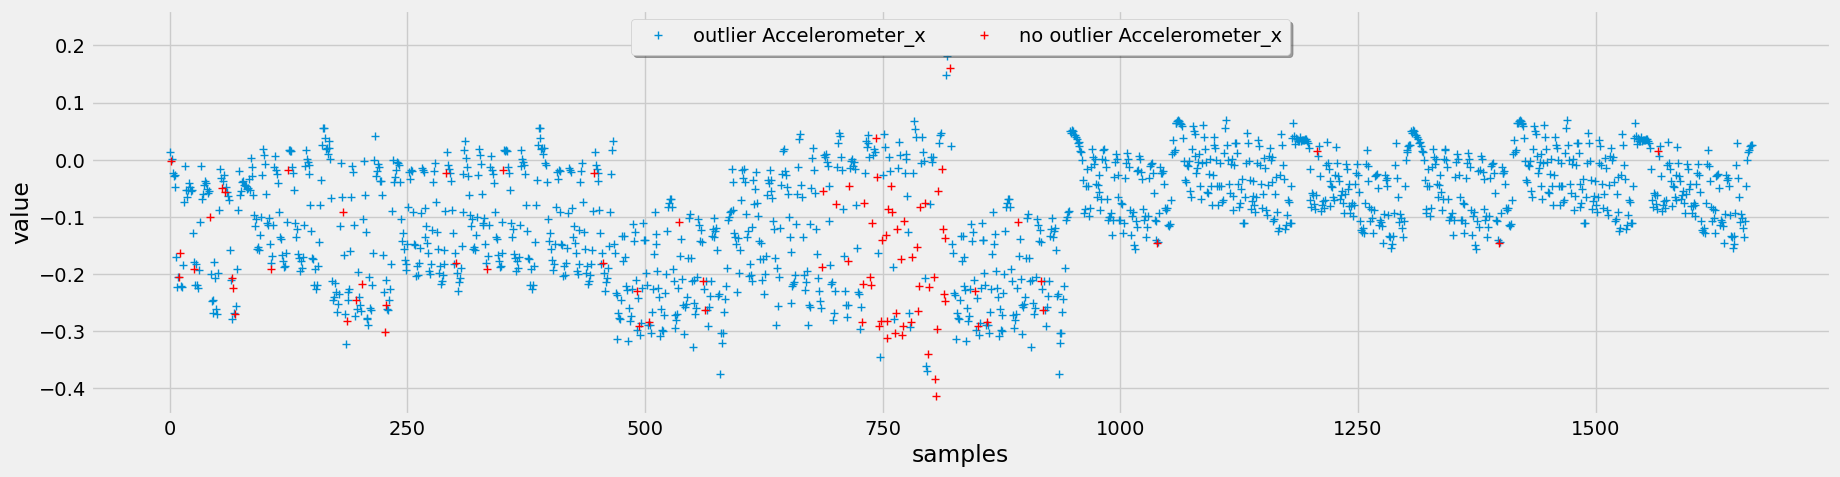

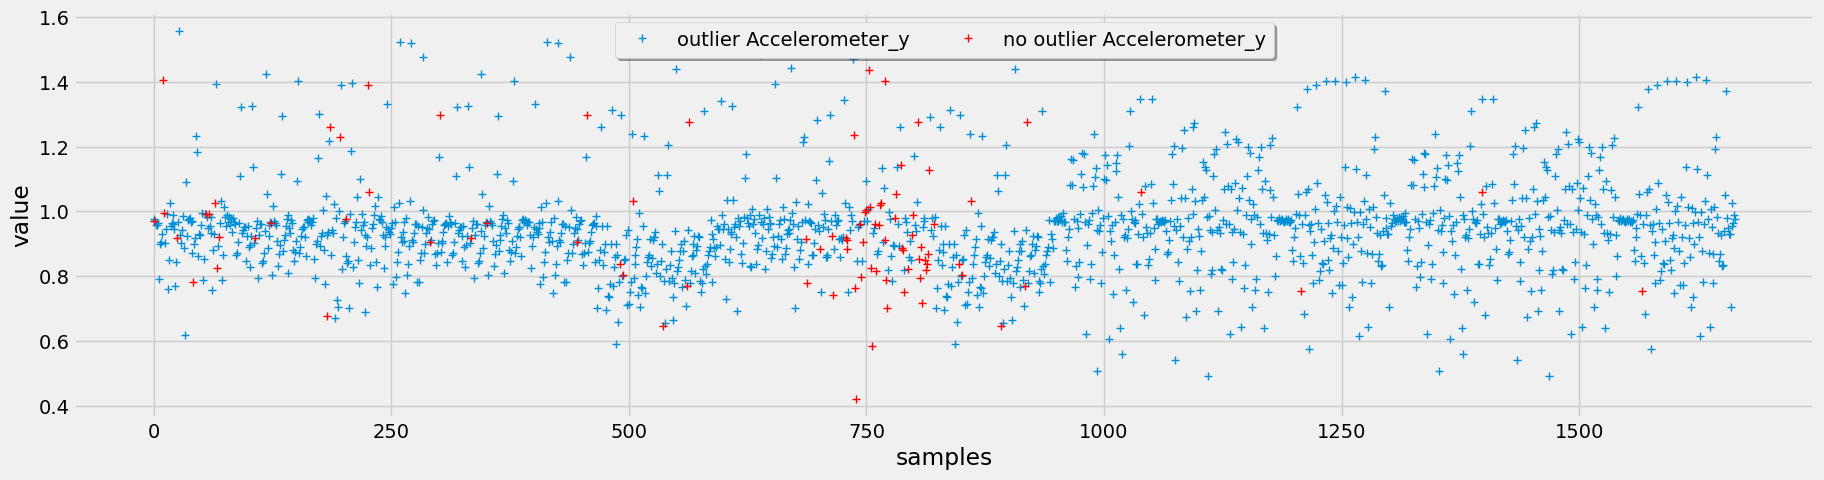

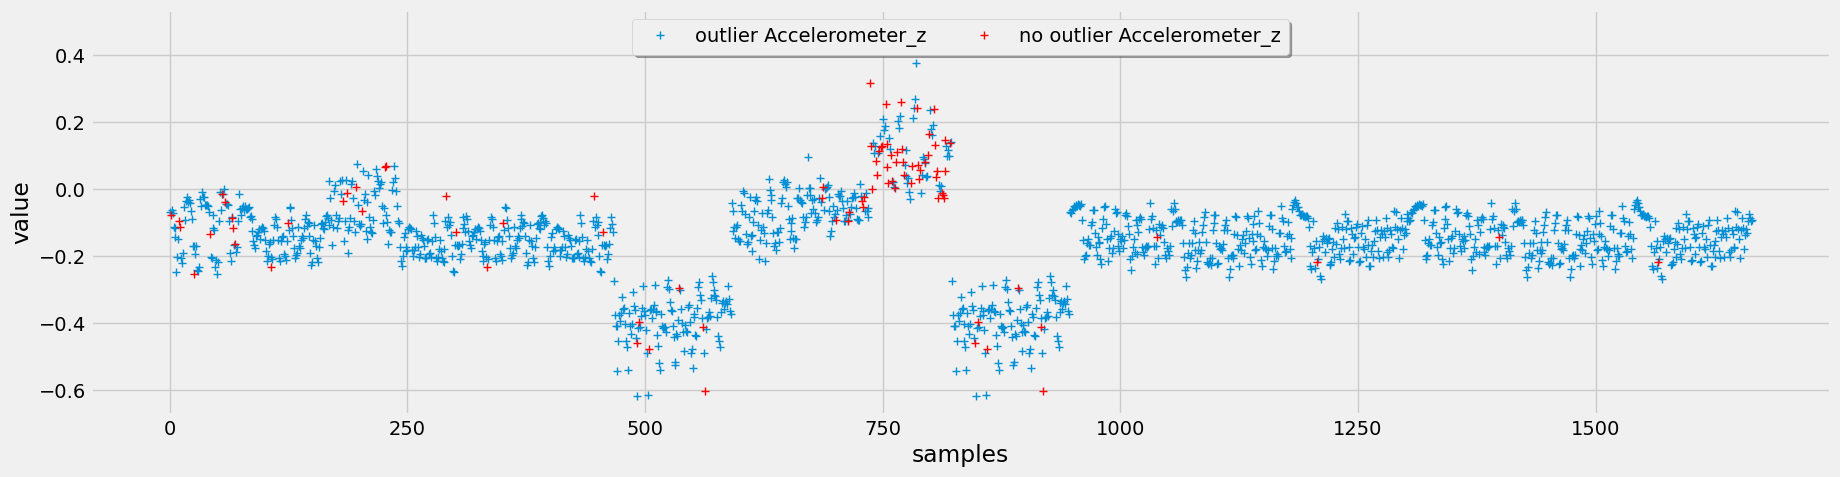

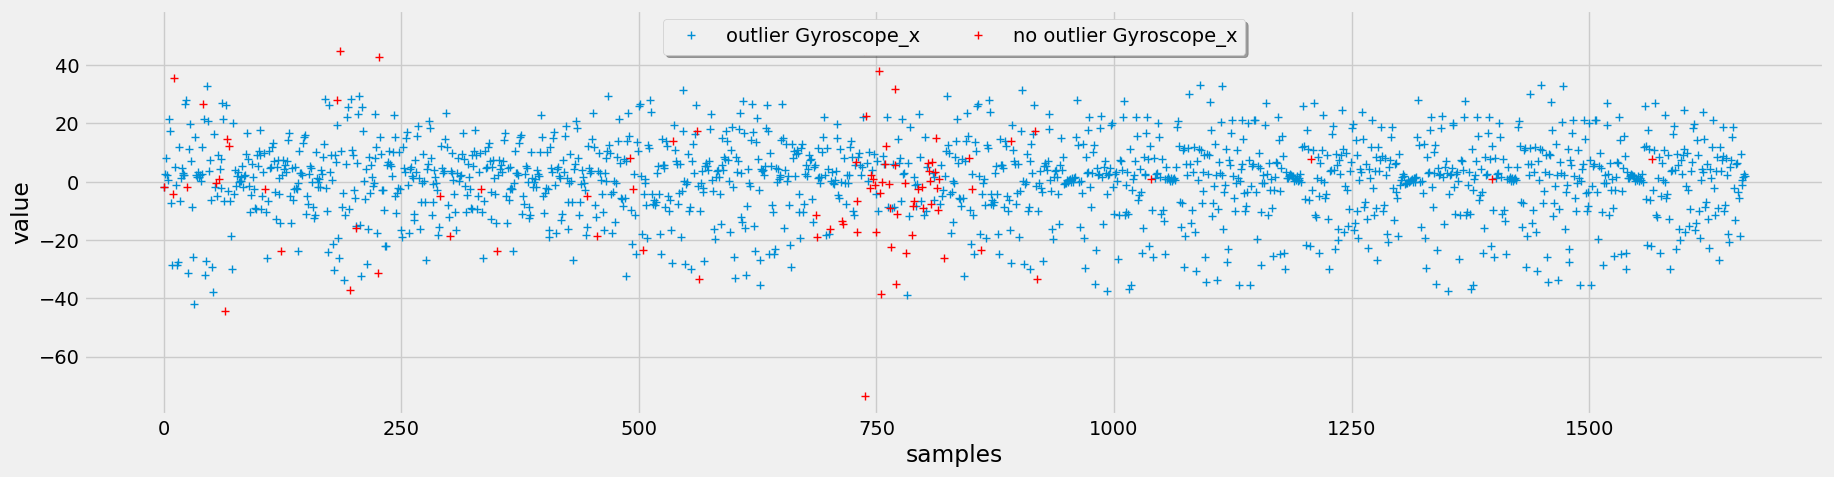

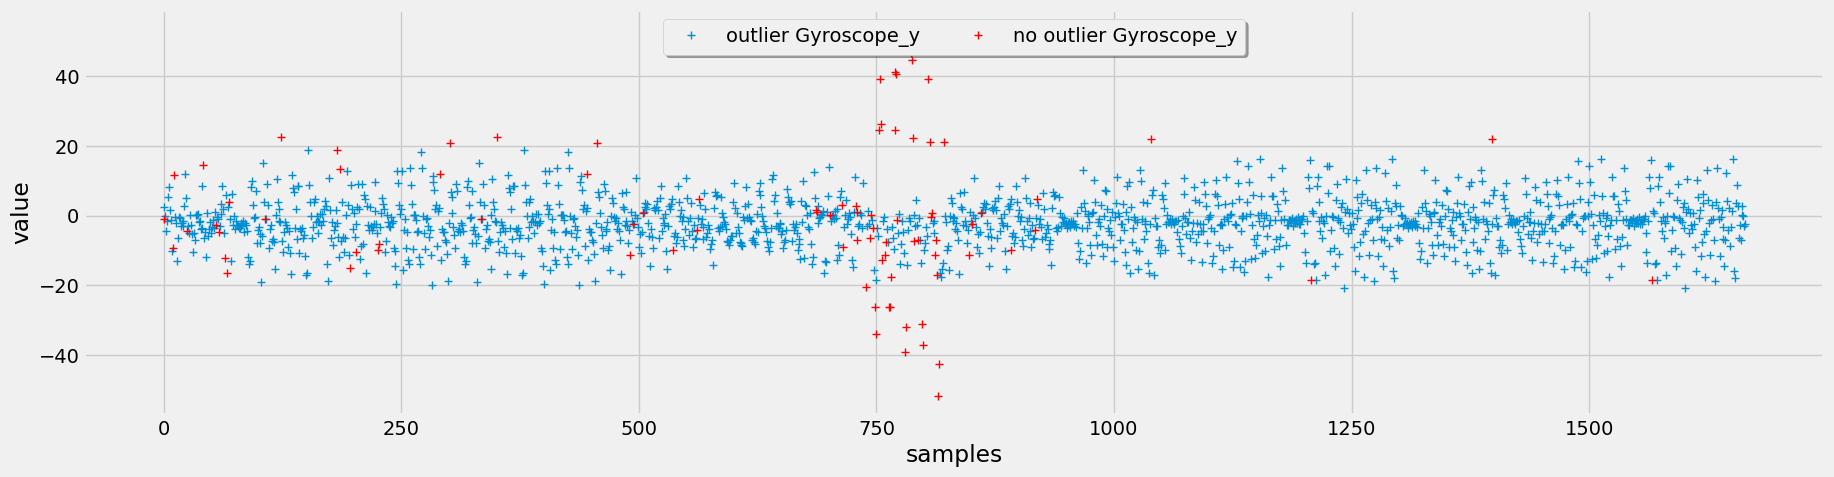

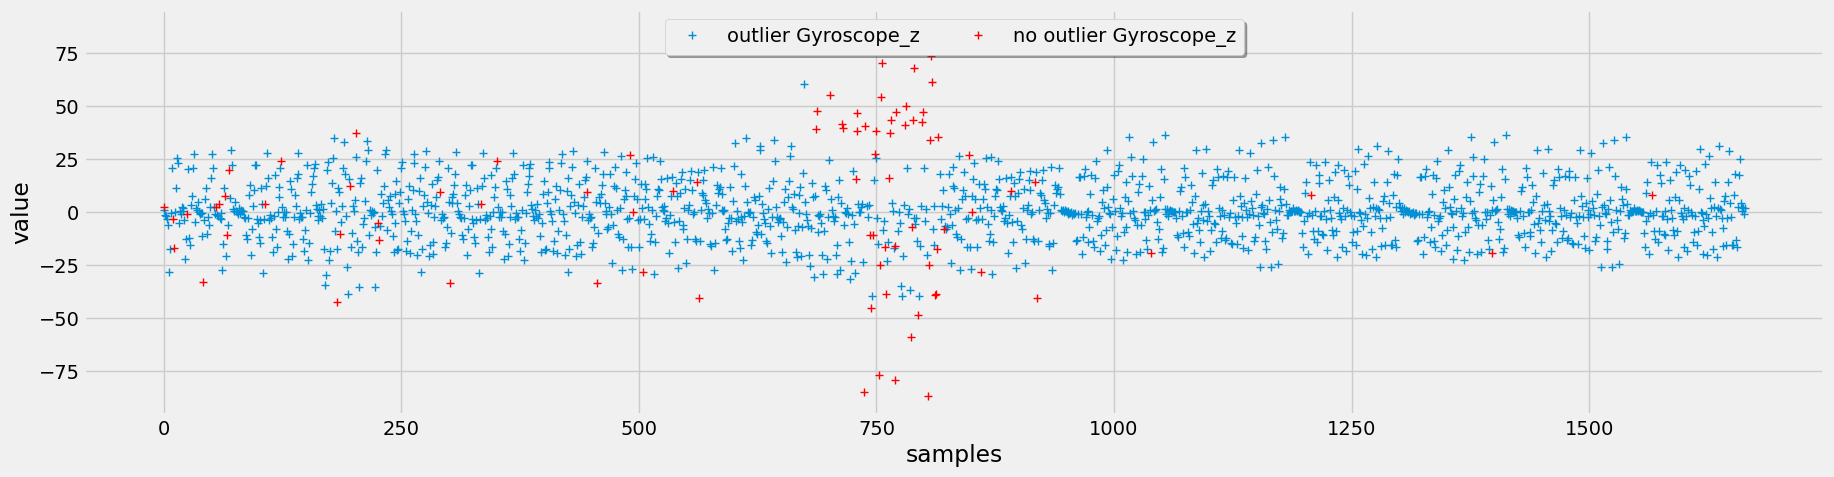

In [11]:
dataset,out,x=mark_outliers_lof(df[df["Label"]==label],outlier_col)

for col in outlier_col:
    plot_binary_outliers(dataset,col,"outlier_lof",True)

In [12]:
outlier_removed_df=df.copy()
for col in outlier_col:
    for label in df["Label"].unique():
        dataset=mark_outliers_chauvenet(df[df["Label"]==label],col)
        dataset.loc[dataset[col + "_outlier"],col]= np.nan
        outlier_removed_df.loc[(outlier_removed_df["Label"]==label),col]=dataset[col]
        n_outliers=len(df) - len(outlier_removed_df[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 0 from Accelerometer_x for bench
Removed 2 from Accelerometer_x for ohp
Removed 2 from Accelerometer_x for squat
Removed 4 from Accelerometer_x for dead


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 4 from Accelerometer_x for row
Removed 4 from Accelerometer_x for rest
Removed 5 from Accelerometer_y for bench
Removed 11 from Accelerometer_y for ohp


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 11 from Accelerometer_y for squat
Removed 11 from Accelerometer_y for dead
Removed 11 from Accelerometer_y for row
Removed 11 from Accelerometer_y for rest


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 3 from Accelerometer_z for bench
Removed 9 from Accelerometer_z for ohp
Removed 9 from Accelerometer_z for squat
Removed 10 from Accelerometer_z for dead


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 10 from Accelerometer_z for row
Removed 10 from Accelerometer_z for rest
Removed 2 from Gyroscope_x for bench
Removed 6 from Gyroscope_x for ohp


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 7 from Gyroscope_x for squat
Removed 13 from Gyroscope_x for dead
Removed 13 from Gyroscope_x for row
Removed 25 from Gyroscope_x for rest
Removed 14 from Gyroscope_y for bench
Removed 29 from Gyroscope_y for ohp


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 38 from Gyroscope_y for squat
Removed 52 from Gyroscope_y for dead
Removed 62 from Gyroscope_y for row
Removed 71 from Gyroscope_y for rest
Removed 13 from Gyroscope_z for bench


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 14 from Gyroscope_z for ohp
Removed 26 from Gyroscope_z for squat


/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
/tmp/ipykernel_6488/170261031.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scip

Removed 40 from Gyroscope_z for dead
Removed 40 from Gyroscope_z for row
Removed 64 from Gyroscope_z for rest


In [13]:
outlier_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Accelerometer_x  9005 non-null   float64
 1   Accelerometer_y  8998 non-null   float64
 2   Accelerometer_z  8999 non-null   float64
 3   Gyroscope_x      8984 non-null   float64
 4   Gyroscope_y      8938 non-null   float64
 5   Gyroscope_z      8945 non-null   float64
 6   Participants     9009 non-null   object 
 7   Label            9009 non-null   object 
 8   Category         9009 non-null   object 
 9   Set              9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


In [14]:
outlier_removed_df.to_pickle("../data/interim/02_Outlier_Removed_Data.pkl")